<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Memory
from tempfile import mkdtemp
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV, SGDRegressor, Lasso, Ridge, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split,KFold
from sklearn.feature_selection import SelectKBest, RFECV, chi2, f_regression, mutual_info_regression,f_classif,RFE
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve,auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import pickle 
from imblearn.over_sampling import SVMSMOTE, SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as imPipeline



sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [2]:
# Feature_coef = pickle.load(open("save_Feature_coef.p", 'rb'))
# Feature_coef = Feature_coef[0]
# KB_Ridge = pickle.load(open("save_result2KB_ridge.p", 'rb'))
# KB_Ridge = KB_Ridge[0]
# RFECV_Ridge, RFECV_Lasso = pickle.load(open("save_result2KB_RFECV.p", 'rb'))
KB_LR, elasticNet, ridge, lasso = pickle.load(open("save_result_q1_part.p", 'rb'))
KB_LR_q2, elasticNet_q2, ridge_q2, lasso_q2 = pickle.load(open("save_result_q2_part.p", 'rb'))

RFECV_GS = pickle.load( open( "save_result_q1_RFECV.p", "rb" ) )
RFECV_GS=RFECV_GS[0]

RFECV_GS_q2 = pickle.load( open( "save_result_q2_RFECV.p", "rb" ) )
RFECV_GS_q2 = RFECV_GS_q2[0]

smt_logR_Grid = pickle.load( open( "save_result_q3_t4.p", "rb" ) )
smt_logR_Grid = smt_logR_Grid[0]

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Data exploration

In [3]:
# Load the data
# Take NA as 'NA' instead of transfering to nan, since NA do have specific meaning in the data description.
house = pd.read_csv('./housing.csv', keep_default_na=False, na_values=[''])

In [4]:
# getting house info
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-

In [5]:
# check house dimension
house.shape

(1460, 81)

In [6]:
# check the content of object column
# find LotFrontage, MasVnrArea, GarageYrBlt are numerical values that having missing data
for col in house.columns:
    if house[col].dtypes == object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column MSZoning, the unique values are ['RL' 'RM' 'C (all)' 'FV' 'RH']
For the column LotFrontage, the unique values are ['65' '80' '68' '60' '84' '85' '75' 'NA' '51' '50' '70' '91' '72' '66'
 '101' '57' '44' '110' '98' '47' '108' '112' '74' '115' '61' '48' '33' '52'
 '100' '24' '89' '63' '76' '81' '95' '69' '21' '32' '78' '121' '122' '40'
 '105' '73' '77' '64' '94' '34' '90' '55' '88' '82' '71' '120' '107' '92'
 '134' '62' '86' '141' '97' '54' '41' '79' '174' '99' '67' '83' '43' '103'
 '93' '30' '129' '140' '35' '37' '118' '87' '116' '150' '111' '49' '96'
 '59' '36' '56' '102' '58' '38' '109' '130' '53' '137' '45' '106' '104'
 '42' '39' '144' '114' '128' '149' '313' '168' '182' '138' '160' '152'
 '124' '153' '46']
For the column Street, the unique values are ['Pave' 'Grvl']
For the column Alley, the unique values are ['NA' 'Grvl' 'Pave']
For the column LotShape, the unique values are ['Reg' 'IR1' 'IR2' 'IR3']
For the column LandContour, the unique values are ['Lvl' 'Bnk' 'Low'

In [7]:
# check numerial unique value
for col in house.columns:
    if house[col].dtypes != object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column Id, the unique values are [   1    2    3 ..., 1458 1459 1460]
For the column MSSubClass, the unique values are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
For the column LotArea, the unique values are [ 8450  9600 11250 ..., 17217 13175  9717]
For the column OverallQual, the unique values are [ 7  6  8  5  9  4 10  3  1  2]
For the column OverallCond, the unique values are [5 8 6 7 4 2 3 9 1]
For the column YearBuilt, the unique values are [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006 1960
 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966 1959 1994
 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972 1921 1945 1982
 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985 1979 1885 1919 1990
 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926 1940 1941 1987 1986 2008
 1908 1892 1916 1932 1918 1912 1947 1925 1900 1980 1989 1992 1949 1880 1928
 1978 1922 1996 2010 1946 1913 1937 1942 1938 1974 1893 1914 1906 

In [8]:
# check MSZoning, there are non residential house
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [9]:
# remove non-residential house
residential = [True if ele in ['RL', 'RM', 'FV', 'RH'] else False for ele in house.MSZoning]
house_residential = house[residential].copy()
house_residential.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [10]:
# set LotFrontage NA value to 0, since there is no zero value exist, consider as input error, 0 feet is record as NA
# convert to int
house_residential.LotFrontage = [0 if ele=='NA' else int(ele) for ele in house_residential.LotFrontage]

In [11]:
# recheck the value of LotFrontage
house_residential['LotFrontage'].unique()

array([ 65,  80,  68,  60,  84,  85,  75,   0,  51,  50,  70,  91,  72,
        66, 101,  57,  44, 110,  98,  47, 108, 112,  74, 115,  61,  48,
        33,  52, 100,  24,  89,  63,  76,  81,  95,  69,  21,  32,  78,
       121, 122,  40,  73,  77,  64,  94, 105,  34,  90,  55,  88,  82,
        71, 120, 107,  92, 134,  62,  86, 141,  97,  54,  41,  79, 174,
        99,  67,  83,  43, 103,  93,  30, 129, 140,  35,  37, 118,  87,
       116, 150, 111,  49,  96,  59,  36,  56, 102,  58,  38, 109, 130,
        53, 137,  45, 106, 104,  42,  39, 144, 114, 128, 149, 313, 168,
       182, 138, 160, 152, 124, 153,  46], dtype=int64)

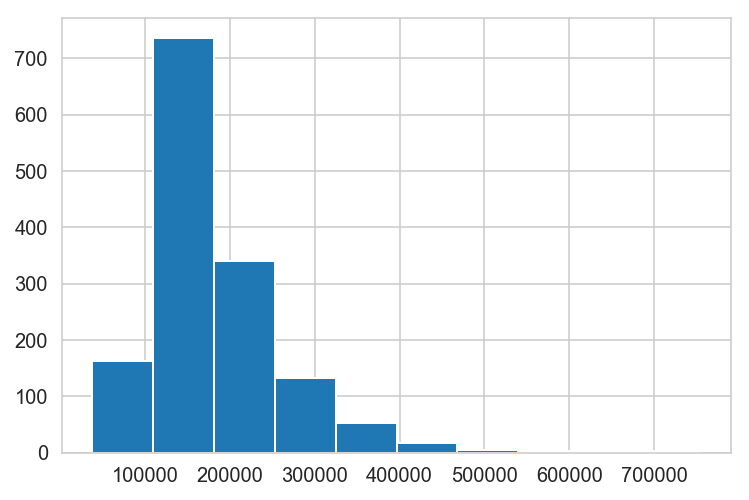

In [12]:
# Take a look of the house price distribution
# there are few very large values
house_residential.SalePrice.hist()

In [13]:
# checking basment exposure, No is no exposure, NA is no basement
house_residential.BsmtExposure.value_counts()

No    947
Av    219
Gd    134
Mn    112
NA     38
Name: BsmtExposure, dtype: int64

In [14]:
# Take a look at the no basement house
# item 948 basement exist, BsmtExposure change to No
house_residential.loc[house_residential.BsmtExposure=='NA', ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NA,NA,NA,NA,0,NA,0,0,0,0
39,NA,NA,NA,NA,0,NA,0,0,0,0
90,NA,NA,NA,NA,0,NA,0,0,0,0
102,NA,NA,NA,NA,0,NA,0,0,0,0
156,NA,NA,NA,NA,0,NA,0,0,0,0
182,NA,NA,NA,NA,0,NA,0,0,0,0
259,NA,NA,NA,NA,0,NA,0,0,0,0
342,NA,NA,NA,NA,0,NA,0,0,0,0
362,NA,NA,NA,NA,0,NA,0,0,0,0
371,NA,NA,NA,NA,0,NA,0,0,0,0


In [15]:
# setting 948, 'BsmtExposure' = 'No'
house_residential.loc[948, 'BsmtExposure'] = 'No'

In [16]:
# checking other basement related columns
# item 332 basement exist but missing BsmtFinType2 (NA means no basement, which is not the incorrect info of this house)
house_residential.loc[house_residential.BsmtFinType2=='NA', ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NA,NA,NA,NA,0,NA,0,0,0,0
39,NA,NA,NA,NA,0,NA,0,0,0,0
90,NA,NA,NA,NA,0,NA,0,0,0,0
102,NA,NA,NA,NA,0,NA,0,0,0,0
156,NA,NA,NA,NA,0,NA,0,0,0,0
182,NA,NA,NA,NA,0,NA,0,0,0,0
259,NA,NA,NA,NA,0,NA,0,0,0,0
332,Gd,TA,No,GLQ,1124,NA,479,3206,1,0
342,NA,NA,NA,NA,0,NA,0,0,0,0
362,NA,NA,NA,NA,0,NA,0,0,0,0


In [17]:
# setting 332, 'BsmtFinType2' = 'othr'
house_residential.loc[332, 'BsmtFinType2'] = 'othr'

In [18]:
# some house missing masonry veneer type, set area to 0
house_residential.loc[house_residential.MasVnrArea=='NA',['MasVnrType','MasVnrArea' ]]

,MasVnrType,MasVnrArea
234,NA,NA
529,NA,NA
650,NA,NA
936,NA,NA
973,NA,NA
977,NA,NA
1243,NA,NA
1278,NA,NA


In [19]:
house_residential.MasVnrArea = [0 if ele=='NA' else int(ele) for ele in house_residential.MasVnrArea]

In [20]:
# change None to NA, the None also repersent not exist. To keep the consistency with other columns
house_residential.loc[house_residential.MasVnrType=='None','MasVnrType']='NA'

In [21]:
# fit the missing electrical with the most common type SBrkr, since in the dictionary do not indicate what is NA repersent for
# Electrical, take ask incorrect input
house_residential.loc[house_residential.Electrical=='NA','Electrical']= house_residential.Electrical.value_counts().index[0]

In [22]:
# Checking Garage info
house_residential.loc[house_residential.GarageYrBlt=='NA',['GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']]


,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt
39,NA,NA,NA,NA,NA
48,NA,NA,NA,NA,NA
78,NA,NA,NA,NA,NA
89,NA,NA,NA,NA,NA
99,NA,NA,NA,NA,NA
108,NA,NA,NA,NA,NA
125,NA,NA,NA,NA,NA
127,NA,NA,NA,NA,NA
140,NA,NA,NA,NA,NA
148,NA,NA,NA,NA,NA


In [23]:
# set garageYrBlt to numerical, NA to 0, varified with GarageCond, this column later will be used in garage age calculation,
# put no garage build year as 0 for now
house_residential.GarageYrBlt = [0 if ele=='NA' else int(ele) for ele in house_residential.GarageYrBlt]

In [24]:
# recheck the object data
for col in house_residential.columns:
    if house_residential[col].dtypes == object:
        print(f"For the column {col}, the unique values are {house_residential[col].unique()}")

For the column MSZoning, the unique values are ['RL' 'RM' 'FV' 'RH']
For the column Street, the unique values are ['Pave' 'Grvl']
For the column Alley, the unique values are ['NA' 'Grvl' 'Pave']
For the column LotShape, the unique values are ['Reg' 'IR1' 'IR2' 'IR3']
For the column LandContour, the unique values are ['Lvl' 'Bnk' 'Low' 'HLS']
For the column Utilities, the unique values are ['AllPub' 'NoSeWa']
For the column LotConfig, the unique values are ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
For the column LandSlope, the unique values are ['Gtl' 'Mod' 'Sev']
For the column Neighborhood, the unique values are ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
For the column Condition1, the unique values are ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
For the column C

In [25]:
# recheck the numerial data
house_residential.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,57.54000,10523.831724,6.114483,5.582069,1971.593103,1985.049655,103.828276,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,34.71992,10012.185355,1.372860,1.107330,30.022696,20.552319,181.150114,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,0.00000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,41.25000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,63.00000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,79.00000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.000000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.00000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Feature engieering

In [26]:
# merge the Porch area
house_residential['PorchSF'] = house_residential[['OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)

In [27]:
# add the age of building when it was sold
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='YearBuilt')[0,0] +1), column='sold_built_age', value=(house_residential.YrSold - house_residential.YearBuilt))

In [28]:
# add age of the renovation of the building when it was sold
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='YearRemodAdd')[0,0] +1), column='sold_Remod_age', value=(house_residential.YrSold - house_residential.YearRemodAdd))

In [29]:
# there is one building that renovated after sold, so change the value to 0, means newly renovated when sold
house_residential.loc[house_residential.sold_Remod_age==-1, ['sold_Remod_age', 'YearRemodAdd', 'YrSold', 'YearBuilt']]

,sold_Remod_age,YearRemodAdd,YrSold,YearBuilt
523,-1,2008,2007,2007


In [30]:
house_residential.loc[house_residential.sold_Remod_age==-1, 'sold_Remod_age'] = 0

In [31]:
# add Garage age
gAge = (house_residential.YrSold - house_residential.GarageYrBlt)

In [32]:
# get a list whether there is garage, by checking the age of the garage
H_gar = [1 if age<200 else 0 for age in gAge]

In [33]:
# fixed the house without garage to garage age = 1000, will be compensate by the having garage column
gAge = [age if age<200 else 1000 for age in gAge]

In [34]:
# add garage age
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='GarageYrBlt')[0,0] +1), column='sold_Garage_age', value=gAge)

In [35]:
# add where have garage
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='GarageYrBlt')[0,0] +1), column='have_garage', value=H_gar)

In [36]:
# check Garage info
house_residential[['sold_Garage_age', 'sold_Remod_age', 'sold_built_age']].describe()

,sold_Garage_age,sold_Remod_age,sold_built_age
count,1450.000000,1450.000000,1450.000000
mean,82.075862,22.763448,36.219310
std,221.717391,20.540721,30.064048
min,0.000000,0.000000,0.000000
25%,7.000000,4.000000,7.000000
50%,30.000000,14.000000,34.000000
75%,50.000000,41.000000,54.000000
max,1000.000000,60.000000,136.000000


In [37]:
# all column of the data
house_residential.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'sold_built_age', 'YearRemodAdd', 'sold_Remod_age', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'have_garage', 'sold_Garage_age', 'GarageFinish

## Fixed ch selecting

In [38]:
# taking the total ground area, and the total porch area as fixed column, remove the first seond floor area, and different porchs
# keep garageCars, do not select redundant garagearea
fixed_ch = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
            'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
            'sold_built_age', 'sold_Remod_age',  'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure',
            'TotalBsmtSF',  'GrLivArea', 'BsmtFullBath', 
            'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
            'TotRmsAbvGrd', 'Fireplaces', 'have_garage', 'GarageType', 'sold_Garage_age', 'GarageCars',
            'PorchSF','PoolArea', 'MiscFeature', 'MiscVal']

In [39]:
# check the rest of the column
rest_ch = [col for col in house_residential.columns if col not in fixed_ch]
rest_ch = rest_ch[1:-1]
rest_ch

['OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolQC',
 'Fence',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

## Review time factors

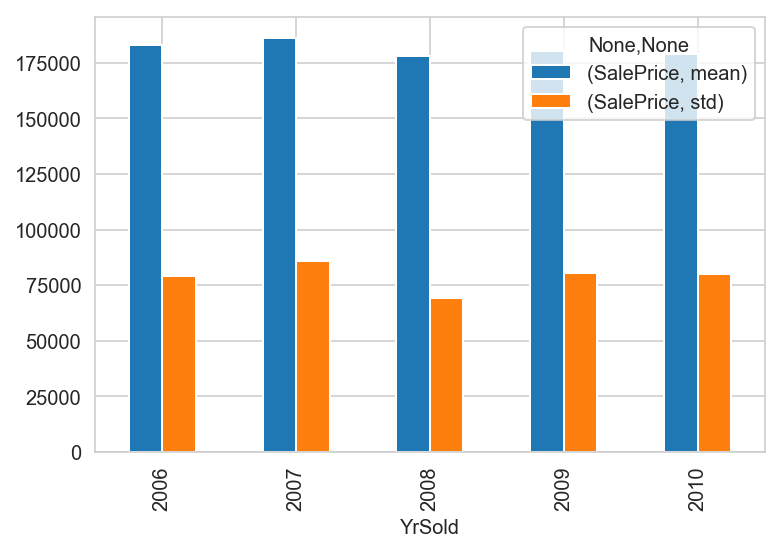

In [40]:
# plot sold year price info
house_residential.groupby(['YrSold']).agg({'SalePrice': ['mean','std'] }).plot(kind='bar')

In [41]:
# setting functions to check the significant difference by p-value, if nothing print, means no significant different


def p_year_test(house_residential, year1, year2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.YrSold==year1, 'SalePrice'],house_residential.loc[ house_residential.YrSold==year2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {year1} and {year2} the p_value is {p_value}\n')

        
def p_year_build_test(house_residential, year1, year2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.YearBuilt==year1, 'SalePrice'],house_residential.loc[ house_residential.YearBuilt==year2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {year1} and {year2} the p_value is {p_value}\n')        
        
        
        
def p_month_test(house_residential, m1, m2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.MoSold==m1, 'SalePrice'],house_residential.loc[ house_residential.MoSold==m2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {m1} and {m2} the p_value is {p_value}\n')

In [42]:
# check if there is significant difference between the price of each sold year
# no significant difference, it is possible to use pass year data to predict 2010 price
for year in range(2006,2011):
    for compare in range(year+1,2011):
        p_year_test(house_residential, year, compare)

In [43]:
# check whether there is significant difference between the price of building year
# build year do give difference
for year in range(1950,2011):
    for compare in range(year+1,2011):
        p_year_build_test(house_residential, year, compare)

Between 1950 and 1960 the p_value is 0.006999309961260744

Between 1950 and 1964 the p_value is 0.0019898023011491015

Between 1950 and 1966 the p_value is 0.016036172417833224

Between 1950 and 1968 the p_value is 0.0027678743161151237

Between 1950 and 1969 the p_value is 0.008395118412309936

Between 1950 and 1974 the p_value is 0.001205281675727996

Between 1950 and 1976 the p_value is 0.003829503311702932

Between 1950 and 1977 the p_value is 0.0004173916377547709

Between 1950 and 1978 the p_value is 0.006518684319980653

Between 1950 and 1980 the p_value is 0.0167371288557425

Between 1950 and 1981 the p_value is 3.292807010855059e-05

Between 1950 and 1983 the p_value is 0.045815783936969424

Between 1950 and 1984 the p_value is 0.012397132311155848

Between 1950 and 1985 the p_value is 0.004018085628005743

Between 1950 and 1986 the p_value is 0.00019438595336002066

Between 1950 and 1987 the p_value is 0.0034311087920962887

Between 1950 and 1988 the p_value is 2.013488234219

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\numpy\core\fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)



Between 1952 and 1998 the p_value is 0.002373534061734119

Between 1952 and 1999 the p_value is 0.004899020221956399

Between 1952 and 2000 the p_value is 0.0004427442030547711

Between 1952 and 2001 the p_value is 0.001225519445634935

Between 1952 and 2002 the p_value is 9.403551806485982e-06

Between 1952 and 2003 the p_value is 0.016995263843566342

Between 1952 and 2004 the p_value is 0.010205262950295129

Between 1952 and 2005 the p_value is 0.012638360191230009

Between 1952 and 2006 the p_value is 0.002502425718031746

Between 1952 and 2007 the p_value is 0.0007069153832594807

Between 1952 and 2008 the p_value is 0.0007454385074537195

Between 1952 and 2009 the p_value is 0.019229447482370158

Between 1953 and 1981 the p_value is 0.003794905329000163

Between 1953 and 1986 the p_value is 0.014541872277199807

Between 1953 and 1988 the p_value is 0.0016253944692114126

Between 1953 and 1989 the p_value is 0.0003894755071917877

Between 1953 and 1990 the p_value is 0.0019599508


Between 1959 and 1986 the p_value is 0.027975171388518322

Between 1959 and 1988 the p_value is 0.005158052704165417

Between 1959 and 1989 the p_value is 0.0004261530331626915

Between 1959 and 1990 the p_value is 0.0011513298541580925

Between 1959 and 1992 the p_value is 0.0032884207014623225

Between 1959 and 1993 the p_value is 0.0005092557417918222

Between 1959 and 1994 the p_value is 0.0036040054337872158

Between 1959 and 1995 the p_value is 0.00021554666674697856

Between 1959 and 1996 the p_value is 0.0017151726803417999

Between 1959 and 1997 the p_value is 0.0005506072851452538

Between 1959 and 1998 the p_value is 4.915934070055105e-05

Between 1959 and 1999 the p_value is 0.00036655188986267916

Between 1959 and 2000 the p_value is 7.87159052187109e-05

Between 1959 and 2001 the p_value is 3.1196670155224485e-06

Between 1959 and 2002 the p_value is 5.899379358465322e-07

Between 1959 and 2003 the p_value is 0.00011066959035652755

Between 1959 and 2004 the p_value is 0


Between 1967 and 2005 the p_value is 8.159534190058294e-05

Between 1967 and 2006 the p_value is 1.0780286767564476e-06

Between 1967 and 2007 the p_value is 1.0130944267609871e-07

Between 1967 and 2008 the p_value is 3.5424401750977054e-08

Between 1967 and 2009 the p_value is 0.00013175362623955695

Between 1968 and 1970 the p_value is 0.025667356802915302

Between 1968 and 1971 the p_value is 0.015508788254449457

Between 1968 and 1981 the p_value is 0.003148320311506571

Between 1968 and 1986 the p_value is 0.04538340659824391

Between 1968 and 1988 the p_value is 0.014006427418924928

Between 1968 and 1989 the p_value is 0.0002986534024375036

Between 1968 and 1990 the p_value is 0.004069408151376547

Between 1968 and 1992 the p_value is 0.01275483279446025

Between 1968 and 1993 the p_value is 0.002769908704743214

Between 1968 and 1994 the p_value is 0.014881057114070855

Between 1968 and 1995 the p_value is 0.0013490909685553091

Between 1968 and 1996 the p_value is 0.0072927


Between 1978 and 1986 the p_value is 0.017461453599096063

Between 1978 and 1988 the p_value is 0.0032024810169637738

Between 1978 and 1989 the p_value is 7.657369864783785e-05

Between 1978 and 1990 the p_value is 0.0025287167233737848

Between 1978 and 1992 the p_value is 0.011053135822653543

Between 1978 and 1993 the p_value is 0.0019426826242170015

Between 1978 and 1994 the p_value is 0.024412732286553815

Between 1978 and 1995 the p_value is 0.0030233693936960555

Between 1978 and 1996 the p_value is 0.013466349459997357

Between 1978 and 1997 the p_value is 0.0006636299574318453

Between 1978 and 1998 the p_value is 0.0004141382765016256

Between 1978 and 1999 the p_value is 0.0022481674174724933

Between 1978 and 2000 the p_value is 0.00023478915529626346

Between 1978 and 2001 the p_value is 3.349810816502297e-05

Between 1978 and 2002 the p_value is 7.208522087914981e-07

Between 1978 and 2003 the p_value is 0.002754518811631236

Between 1978 and 2004 the p_value is 0.0042

In [44]:
# month infor also useful, keep the month column for later

for m1 in range(1,13):
    for m2 in range(m1+1,13):
        p_month_test(house_residential, m1, m2)

Between 4 and 9 the p_value is 0.040058419468244975

Between 4 and 11 the p_value is 0.043115189130592556

Between 5 and 9 the p_value is 0.018639526613212224

Between 5 and 11 the p_value is 0.020106790809764075



## Train test splite

In [45]:
# split by year
train_data = house_residential[house_residential.YrSold< 2010 ].copy()
test_data = house_residential[house_residential.YrSold == 2010 ].copy()

In [46]:
# check length
(len(train_data)+len(test_data)) == len(house_residential)

True

In [47]:
# 1278 training data, 172 testing data
print((len(train_data), len(test_data)))

(1278, 172)


## Get dummies

In [48]:
# for training set, get predictor and target

fixed_predictor = train_data[fixed_ch]
y_train = train_data.SalePrice

In [49]:
# convert all categorical data and MSsubClass as dummies
object_col = [col for col in fixed_ch if fixed_predictor[col].dtype==object]
dummy_num_col = ['MSSubClass']
dummy_col = dummy_num_col + object_col
X_train = pd.get_dummies(fixed_predictor, columns=dummy_col, drop_first=True)
# no object datatype
np.argwhere(X_train.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [50]:
# for testing set do the same

fixed_predictor = test_data[fixed_ch]
y_test = test_data.SalePrice
X_test = pd.get_dummies(fixed_predictor, columns=dummy_col, drop_first=True)
# no object
np.argwhere(X_test.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [51]:
# size of training and testing does not match
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((1278, 126), (1278,), (172, 106), (172,))

In [52]:
# there are categoies do not exist in testing data
missing_col = [col for col in X_train.columns if col not in X_test.columns]
missing_col

['MSSubClass_45',
 'MSSubClass_75',
 'MSZoning_RH',
 'LotShape_IR3',
 'Utilities_NoSeWa',
 'LotConfig_FR3',
 'Neighborhood_Blueste',
 'Neighborhood_Veenker',
 'Condition2_Feedr',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'GarageType_Attchd',
 'MiscFeature_NA',
 'MiscFeature_TenC']

In [53]:
# testing data do not have additonal category than training data
[col for col in X_test.columns if col not in X_train.columns]

[]

In [54]:
# finding the missing columns
missing_col_loc = [np.argwhere(X_train.columns==col)[0,0] for col in missing_col]

In [55]:
missing_col_loc

[23,
 27,
 35,
 42,
 47,
 50,
 54,
 77,
 86,
 88,
 89,
 90,
 91,
 92,
 97,
 99,
 100,
 116,
 122,
 125]

In [56]:
list(enumerate(X_train.columns))

[(0, 'LotFrontage'),
 (1, 'LotArea'),
 (2, 'sold_built_age'),
 (3, 'sold_Remod_age'),
 (4, 'MasVnrArea'),
 (5, 'TotalBsmtSF'),
 (6, 'GrLivArea'),
 (7, 'BsmtFullBath'),
 (8, 'BsmtHalfBath'),
 (9, 'FullBath'),
 (10, 'HalfBath'),
 (11, 'BedroomAbvGr'),
 (12, 'KitchenAbvGr'),
 (13, 'TotRmsAbvGrd'),
 (14, 'Fireplaces'),
 (15, 'have_garage'),
 (16, 'sold_Garage_age'),
 (17, 'GarageCars'),
 (18, 'PorchSF'),
 (19, 'PoolArea'),
 (20, 'MiscVal'),
 (21, 'MSSubClass_30'),
 (22, 'MSSubClass_40'),
 (23, 'MSSubClass_45'),
 (24, 'MSSubClass_50'),
 (25, 'MSSubClass_60'),
 (26, 'MSSubClass_70'),
 (27, 'MSSubClass_75'),
 (28, 'MSSubClass_80'),
 (29, 'MSSubClass_85'),
 (30, 'MSSubClass_90'),
 (31, 'MSSubClass_120'),
 (32, 'MSSubClass_160'),
 (33, 'MSSubClass_180'),
 (34, 'MSSubClass_190'),
 (35, 'MSZoning_RH'),
 (36, 'MSZoning_RL'),
 (37, 'MSZoning_RM'),
 (38, 'Street_Pave'),
 (39, 'Alley_NA'),
 (40, 'Alley_Pave'),
 (41, 'LotShape_IR2'),
 (42, 'LotShape_IR3'),
 (43, 'LotShape_Reg'),
 (44, 'LandContour_HLS

In [57]:
# fillin zeros for the missing columns
for i,locnumber in enumerate(missing_col_loc):
    X_test.insert(loc=int(locnumber), column=missing_col[i], value=[0 for ele in range(X_test.shape[0])])

In [58]:
X_test.iloc[:, missing_col_loc].head()

,MSSubClass_45,MSSubClass_75,MSZoning_RH,LotShape_IR3,Utilities_NoSeWa,LotConfig_FR3,Neighborhood_Blueste,Neighborhood_Veenker,Condition2_Feedr,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,GarageType_Attchd,MiscFeature_NA,MiscFeature_TenC
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
X_train.iloc[:, missing_col_loc].head()

,MSSubClass_45,MSSubClass_75,MSZoning_RH,LotShape_IR3,Utilities_NoSeWa,LotConfig_FR3,Neighborhood_Blueste,Neighborhood_Veenker,Condition2_Feedr,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,GarageType_Attchd,MiscFeature_NA,MiscFeature_TenC
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [60]:
# columns matched
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((1278, 126), (1278,), (172, 126), (172,))

## Train and validation

In [61]:
# model 1 LinearRegression
# very bad, will not take into consideration
scaler1 = StandardScaler()
lr = LinearRegression()
X_train_std = scaler1.fit_transform(X_train)
score1 = cross_val_score(lr, X_train_std, y_train, scoring='r2', cv=10)
np.mean(score1), np.std(score1)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(-9.8076336976310441e+21, 2.1858381775736215e+22)

In [62]:
# transfer the test data
X_test_std = scaler1.transform(X_test)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [63]:
# # model 2 Lasso
# # using Lasso model to remove features not important
# # The CV score mean is 0.794701402761934, the CV score std is 0.10113348603590319
# # 0.86041448799049192

# lassoCV = LassoCV(alphas=np.linspace(1050, 1100, 400), random_state=42, cv=10, max_iter=5000)
# lassoCV.fit(X_train_std, y_train)
# print(f'alpha is {lassoCV.alpha_}')
# lasso = Lasso(alpha=lassoCV.alpha_, random_state=42, max_iter=5000)


In [64]:
score2 = cross_val_score(lasso, X_train_std, y_train, scoring='r2', cv=10)
print(f"The CV score mean is {np.mean(score2)}, the CV score std is {np.std(score2)}")
lasso.fit(X_train_std,y_train)
lasso.score(X_test_std,y_test)

The CV score mean is 0.794701402761934, the CV score std is 0.10113348603590319


0.86041448799049192

In [65]:
# append result
Score_method = pd.DataFrame()

Score_method.loc["CV_train_score", "Lasso"] = np.mean(score2)
Score_method.loc["Test_score", "Lasso"] = lasso.score(X_test_std,y_test)

In [66]:
# add coef to feature df
Feature_coef = pd.DataFrame(data=lasso.coef_, index=X_train.columns, columns=['Lasso'])
Feature_coef.loc['Intercept', 'Lasso'] = lasso.intercept_
Feature_coef.iloc[np.argsort(Feature_coef.Lasso.abs())[::-1]].head(64)

,Lasso
Intercept,181989.782473
GrLivArea,29989.196276
Neighborhood_NridgHt,13626.821816
GarageCars,9000.841317
Neighborhood_NoRidge,8448.528902
sold_built_age,-8153.387180
Neighborhood_StoneBr,7896.777277
sold_Remod_age,-7537.485375
TotalBsmtSF,6975.574557
KitchenAbvGr,-5363.892732


In [67]:
# # model 3 ridge 
# # The CV score mean 0.7987595839533944, the CV score std 0.08542816795119058
# # Test score 0.85903518620981123

# ridgeCV = RidgeCV(alphas=np.linspace(320, 330, 100), cv=10,scoring='r2')
# ridgeCV.fit(X_train_std, y_train)
# print(f'alpha is {ridgeCV.alpha_}')
# ridge = Ridge(alpha=ridgeCV.alpha_,random_state=42, max_iter=5000)


In [68]:
score3 = cross_val_score(ridge,X_train_std, y_train, scoring='r2', cv=10)
print(f"The CV score mean {np.mean(score3)}, the CV score std {np.std(score3)}")
ridge.fit(X_train_std,y_train)
ridge.score(X_test_std, y_test)

The CV score mean 0.7987595839533944, the CV score std 0.08542816795119058


0.85903518620981123

In [69]:
Score_method.loc["CV_train_score", "Ridge"] = np.mean(score3)
Score_method.loc["Test_score", "Ridge"] = ridge.score(X_test_std, y_test)

In [70]:
# add Ridge coef
Feature_coef.loc[:-1,'Ridge'] = ridge.coef_
Feature_coef.loc['Intercept','Ridge'] = ridge.intercept_
Feature_coef.iloc[np.argsort(Feature_coef.Ridge.abs())[::-1]].head(20)

,Lasso,Ridge
Intercept,181989.782473,181989.782473
GrLivArea,29989.196276,14706.069064
Neighborhood_NridgHt,13626.821816,9989.277833
GarageCars,9000.841317,8603.197417
TotalBsmtSF,6975.574557,8157.699318
Neighborhood_NoRidge,8448.528902,7644.847296
TotRmsAbvGrd,2533.509865,7342.256519
sold_Remod_age,-7537.485375,-6527.282126
Neighborhood_StoneBr,7896.777277,6521.374215
FullBath,1931.684932,5828.214333


In [71]:
# # model 4 elasticNet

# # The CV score mean 0.7947023840424929, the CV score std 0.10113034239385739
# # Test score is 0.86039680967328902

# l1_ratios=np.linspace(0.001, 1, 100)
# n_alpha = 1000

# elasticNetCV = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=n_alpha, cv=10, max_iter=5000, random_state=42)
# elasticNetCV.fit(X_train_std, y_train)

# print(f"The l1 ration is {elasticNetCV.l1_ratio_}, the alpha is {elasticNetCV.alpha_}")
# elasticNet = ElasticNet(alpha=elasticNetCV.alpha_, l1_ratio=elasticNetCV.l1_ratio_, max_iter=5000)


In [72]:
score4 = cross_val_score(elasticNet,X_train_std, y_train, scoring='r2', cv=10)
print(f"The CV score mean {np.mean(score4)}, the CV score std {np.std(score4)}")

elasticNet.fit(X_train_std, y_train)

elasticNet.score(X_test_std, y_test)

The CV score mean 0.7947023840424929, the CV score std 0.10113034239385739


0.86039680967328902

In [73]:
Score_method.loc["CV_train_score", "ElasticNet"] = np.mean(score4)
Score_method.loc["Test_score", "ElasticNet"] = elasticNet.score(X_test_std, y_test)

In [74]:
## add elastic net feature
Feature_coef.loc[:-1,'ElasticNet'] = elasticNet.coef_
Feature_coef.loc['Intercept','ElasticNet'] = elasticNet.intercept_
Feature_coef.iloc[np.argsort(Feature_coef.ElasticNet.abs())[::-1]].head(20)

,Lasso,Ridge,ElasticNet
Intercept,181989.782473,181989.782473,181989.782473
GrLivArea,29989.196276,14706.069064,29989.866530
Neighborhood_NridgHt,13626.821816,9989.277833,13625.563202
GarageCars,9000.841317,8603.197417,9003.083380
Neighborhood_NoRidge,8448.528902,7644.847296,8447.466920
sold_built_age,-8153.387180,-4851.039214,-8153.394243
Neighborhood_StoneBr,7896.777277,6521.374215,7895.550008
sold_Remod_age,-7537.485375,-6527.282126,-7538.357352
TotalBsmtSF,6975.574557,8157.699318,6978.396216
KitchenAbvGr,-5363.892732,-3774.570660,-5363.110901


In [75]:
# # model 5 SelectKBest + LinearRegression
# # The CV score is 0.7958506986788508
# # Testing score is 0.82048715092243296
# # The best parameters are {'KB__k': 91, 'KB__score_func': <function mutual_info_regression at 0x000002918D6E2510>}

# pipeline_KB_LR = Pipeline([("KB", SelectKBest()), ("LR", LinearRegression())])

# print(f"Hyperparameter: {pipeline_KB_LR.get_params().keys()}")

# KB_LR_parameter = {"KB__k": list(range(1,100)),
#                   "KB__score_func": [f_regression, mutual_info_regression]}

# KB_LR = GridSearchCV(pipeline_KB_LR, KB_LR_parameter, cv=5, scoring="r2", n_jobs=7)
# KB_LR.fit(X_train_std, y_train)


In [76]:
print(f"The best parameters are {KB_LR.best_params_}")
print(f"The CV score is {KB_LR.best_score_}")
KB_lR_predict = KB_LR.predict(X_test_std)
r2_score(y_test, KB_lR_predict)

The best parameters are {'KB__k': 80, 'KB__score_func': <function mutual_info_regression at 0x0000020B85601620>}
The CV score is 0.7958506986788508


0.82048715092243296

In [77]:
Score_method.loc["CV_train_score", "KBest_LR"] = KB_LR.best_score_
Score_method.loc["Test_score", "KBest_LR"] = r2_score(y_test, KB_lR_predict)

In [78]:
# add the feature coef
Feature_coef.loc[:,'KBest_LR']=0
kb_col = X_train.columns[KB_LR.best_estimator_.named_steps['KB'].get_support()]
Feature_coef.loc[kb_col,'KBest_LR']=KB_LR.best_estimator_.named_steps['LR'].coef_
Feature_coef.loc['Intercept','KBest_LR']=KB_LR.best_estimator_.named_steps['LR'].intercept_
Feature_coef.iloc[np.argsort(Feature_coef.KBest_LR.abs())[::-1]].head(20)

,Lasso,Ridge,ElasticNet,KBest_LR
GarageType_NA,0.000000,348.702834,0.000000,-2.347603e+16
have_garage,-0.000000,-348.702834,-0.000000,-2.347603e+16
BldgType_Duplex,-76.867768,-1402.658277,-76.592514,-1.592864e+16
MSSubClass_90,-1301.643429,-1402.658277,-1301.659773,1.592864e+16
Intercept,181989.782473,181989.782473,181989.782473,1.819891e+05
GrLivArea,29989.196276,14706.069064,29989.866530,3.147361e+04
Neighborhood_NridgHt,13626.821816,9989.277833,13625.563202,1.587611e+04
MasVnrType_NA,0.000000,803.213434,0.000000,1.275362e+04
sold_built_age,-8153.387180,-4851.039214,-8153.394243,-1.058735e+04
Neighborhood_NoRidge,8448.528902,7644.847296,8447.466920,1.046563e+04


In [79]:
# # model 6 rfe+linearRegression
# # The CV score is 0.775974015273406
# # The Test score is 0.83200157318431767
# rfeCV = RFE(LinearRegression())

# rfeCV_parameters = {"n_features_to_select": range(1,100),
#               "step": range(1,6) 
# }

# RFECV_GS = GridSearchCV(rfeCV, rfeCV_parameters, cv=5, scoring="r2", n_jobs=7 )
# RFECV_GS.fit(X_train_std, y_train)

In [80]:
print(f"The best parameters are {RFECV_GS.best_params_}")
print(f"The CV score is {RFECV_GS.best_score_}")
RFECV_GS_predict = RFECV_GS.predict(X_test_std)
r2_score(y_test, RFECV_GS_predict)

The best parameters are {'n_features_to_select': 53, 'step': 1}
The CV score is 0.775974015273406


0.83200157318431767

In [81]:
Score_method.loc["CV_train_score", "RFE_LR"] = RFECV_GS.best_score_
Score_method.loc["Test_score", "RFE_LR"] = r2_score(y_test, RFECV_GS_predict)

In [82]:
Feature_coef.loc[:,'RFE_LR']=0
kb_col = X_train.columns[RFECV_GS.best_estimator_.support_]
Feature_coef.loc[kb_col,'RFE_LR']=RFECV_GS.best_estimator_.estimator_.coef_
Feature_coef.loc['Intercept','RFE_LR']=RFECV_GS.best_estimator_.estimator_.intercept_
Feature_coef.iloc[np.argsort(Feature_coef.RFE_LR.abs())[::-1]].head(20)

,Lasso,Ridge,ElasticNet,KBest_LR,RFE_LR
have_garage,-0.000000,-348.702834,-0.000000,-2.347603e+16,-8.068928e+16
GarageType_NA,0.000000,348.702834,0.000000,-2.347603e+16,-8.068928e+16
MSSubClass_90,-1301.643429,-1402.658277,-1301.659773,1.592864e+16,-3.366180e+16
BldgType_Duplex,-76.867768,-1402.658277,-76.592514,-1.592864e+16,3.366180e+16
Intercept,181989.782473,181989.782473,181989.782473,1.819891e+05,1.819873e+05
GrLivArea,29989.196276,14706.069064,29989.866530,3.147361e+04,3.376177e+04
Neighborhood_NridgHt,13626.821816,9989.277833,13625.563202,1.587611e+04,1.415183e+04
MasVnrType_NA,0.000000,803.213434,0.000000,1.275362e+04,1.280809e+04
sold_built_age,-8153.387180,-4851.039214,-8153.394243,-1.058735e+04,-1.247652e+04
MSSubClass_160,-2621.881313,-3158.999736,-2621.295410,-8.992566e+03,-9.950187e+03


In [83]:
# # storing model
# pickle.dump( [ KB_LR, elasticNet, ridge, lasso], open( "save_result_q1_part.p", "wb" ) )
# pickle.dump( [RFECV_GS], open( "save_result_q1_RFECV.p", "wb" ) )

## Voting modole combination

In [84]:
# show the model scores
Score_method

,Lasso,Ridge,ElasticNet,KBest_LR,RFE_LR
CV_train_score,0.794701,0.798760,0.794702,0.795851,0.775974
Test_score,0.860414,0.859035,0.860397,0.820487,0.832002


In [85]:
# combining model voting
# weighted voting of Lasso and Ridge
# not chosed: ElasticNet l10 is 1 so similar to model2, the other two models testing score poor

combined_predict = (lasso.predict(X_test_std)*Score_method.loc["Test_score", "Lasso"] 
                    + ridge.predict(X_test_std)*Score_method.loc["Test_score", "Ridge"]
                     )/Score_method.loc['Test_score',['Lasso','Ridge']].sum()
r2_score(y_test, combined_predict)

0.86256203424983824

In [86]:
# combined coef
combined_predict_coef = (Feature_coef.loc[:, "Lasso"] *Score_method.loc["Test_score", "Lasso"] 
                        + Feature_coef.loc[:, "Ridge"]*Score_method.loc["Test_score", "Ridge"])/Score_method.loc['Test_score',['Lasso','Ridge']].sum()
Feature_coef.loc[:,'Combined'] = combined_predict_coef
Feature_coef.iloc[np.argsort(Feature_coef.Combined.abs())[::-1]].head(30)

,Lasso,Ridge,ElasticNet,KBest_LR,RFE_LR,Combined
Intercept,181989.782473,181989.782473,181989.782473,181989.064601,181987.315082,181989.782473
GrLivArea,29989.196276,14706.069064,29989.866530,31473.607504,33761.766420,22353.762551
Neighborhood_NridgHt,13626.821816,9989.277833,13625.563202,15876.112723,14151.826886,11809.508801
GarageCars,9000.841317,8603.197417,9003.083380,9965.431092,8909.071026,8802.178857
Neighborhood_NoRidge,8448.528902,7644.847296,8447.466920,10465.625902,8769.264038,8047.010446
TotalBsmtSF,6975.574557,8157.699318,6978.396216,-815.118029,0.000000,7566.162801
Neighborhood_StoneBr,7896.777277,6521.374215,7895.550008,10107.236500,8866.002088,7209.627404
sold_Remod_age,-7537.485375,-6527.282126,-7538.357352,-6390.444458,-6315.903830,-7032.788931
sold_built_age,-8153.387180,-4851.039214,-8153.394243,-10587.349763,-12476.523219,-6503.537730
BsmtExposure_Gd,5363.205373,5181.095796,5362.217984,6631.235267,6243.731741,5272.223627


In [87]:
# finally choose the combined model
combined_predict_test = (combined_predict_coef[:-1].dot(X_test_std.T)+combined_predict_coef[-1])
combined_predict_train = (combined_predict_coef[:-1].dot(X_train_std.T)+combined_predict_coef[-1])


In [88]:
print(f"r2 score for test data: {r2_score(y_test, combined_predict_test)}, for train data : {r2_score(y_train, combined_predict_train)}")

r2 score for test data: 0.8625620342498382, for train data : 0.8397004097551941


In [89]:
y_test.describe()

count       172.000000
mean     179167.000000
std       79966.098284
min       55000.000000
25%      128987.500000
50%      156450.000000
75%      213625.000000
max      611657.000000
Name: SalePrice, dtype: float64

## Model explain

### Intercept

In [90]:
# Dummy column reference:
# The Intercept 181989.782473 is the average price of the refence house with:
[col +": " + str(sorted(house_residential[col].unique())[0]) for col in dummy_col]

['MSSubClass: 20',
 'MSZoning: FV',
 'Street: Grvl',
 'Alley: Grvl',
 'LotShape: IR1',
 'LandContour: Bnk',
 'Utilities: AllPub',
 'LotConfig: Corner',
 'LandSlope: Gtl',
 'Neighborhood: Blmngtn',
 'Condition1: Artery',
 'Condition2: Artery',
 'BldgType: 1Fam',
 'HouseStyle: 1.5Fin',
 'MasVnrType: BrkCmn',
 'Foundation: BrkTil',
 'BsmtExposure: Av',
 'GarageType: 2Types',
 'MiscFeature: Gar2']

### Most influence fixed characters

In [91]:
# convert the feature coef from price/std to price/(original unit of feature) 
combined_model_coef = Feature_coef[['Combined']].copy()
combined_model_coef['Price_unit'] = combined_model_coef.apply(lambda x:x*X_train.std()/(X_train.max()-X_train.min()))
combined_model_coef.loc['Intercept','Price_unit'] = combined_model_coef.loc['Intercept','Combined']
combined_model_coef.iloc[np.argsort(combined_model_coef.Combined.abs())[::-1]].head(40)

,Combined,Price_unit
Intercept,181989.782473,181989.782473
GrLivArea,22353.762551,2224.668641
Neighborhood_NridgHt,11809.508801,2669.983973
GarageCars,8802.178857,1648.502303
Neighborhood_NoRidge,8047.010446,1295.458003
TotalBsmtSF,7566.162801,548.197091
Neighborhood_StoneBr,7209.627404,895.173596
sold_Remod_age,-7032.788931,-2451.792582
sold_built_age,-6503.537730,-1449.807669
BsmtExposure_Gd,5272.223627,1555.523209


### Coef explained Top 10 coef
1. The above ground living area give the higherst influence, with coef = 22353.762551, the price for above ground area is 2224.668641/sqft
2. The Neighborhood location matters, coef and price difference compare to reference Bloomington Heights see in below figure 1
3. Garage car number matters, coef 8802.178857, per additional car lot worth 1648.502303 dollar
4. Basement area, coef 7566.162801, worth 548.197091/sqft
5. Age at sold years matter, Remodel age (coef -7032.788931, price -2451.792582/year) is slightly more important than built year (coef -6503.537730, price -1449.807669/year)
6. The next is basement exposure, show in figure 2
7. Total room above ground, coef:4935.954461, price: 667.489896/room
8. Fireplace coef: 4718.191776, price: 1006.435652/Fireplace
9. Number of kitchen above ground compare to normal room: coef:-4569.869154, price: -331.446196/room, e.g. if a room is a kitch it worth 667.489896-331.446196 = 336.04370000000006 /room instead of 667.489896 dollar as factor 7
10. MasVnrArea coef: 4516.110100, price 522.040259/sqft (type:BrkCmn)

Text(0.5, 0, 'coef/unit_std, price/location (ref: Bloomington Heights) ')

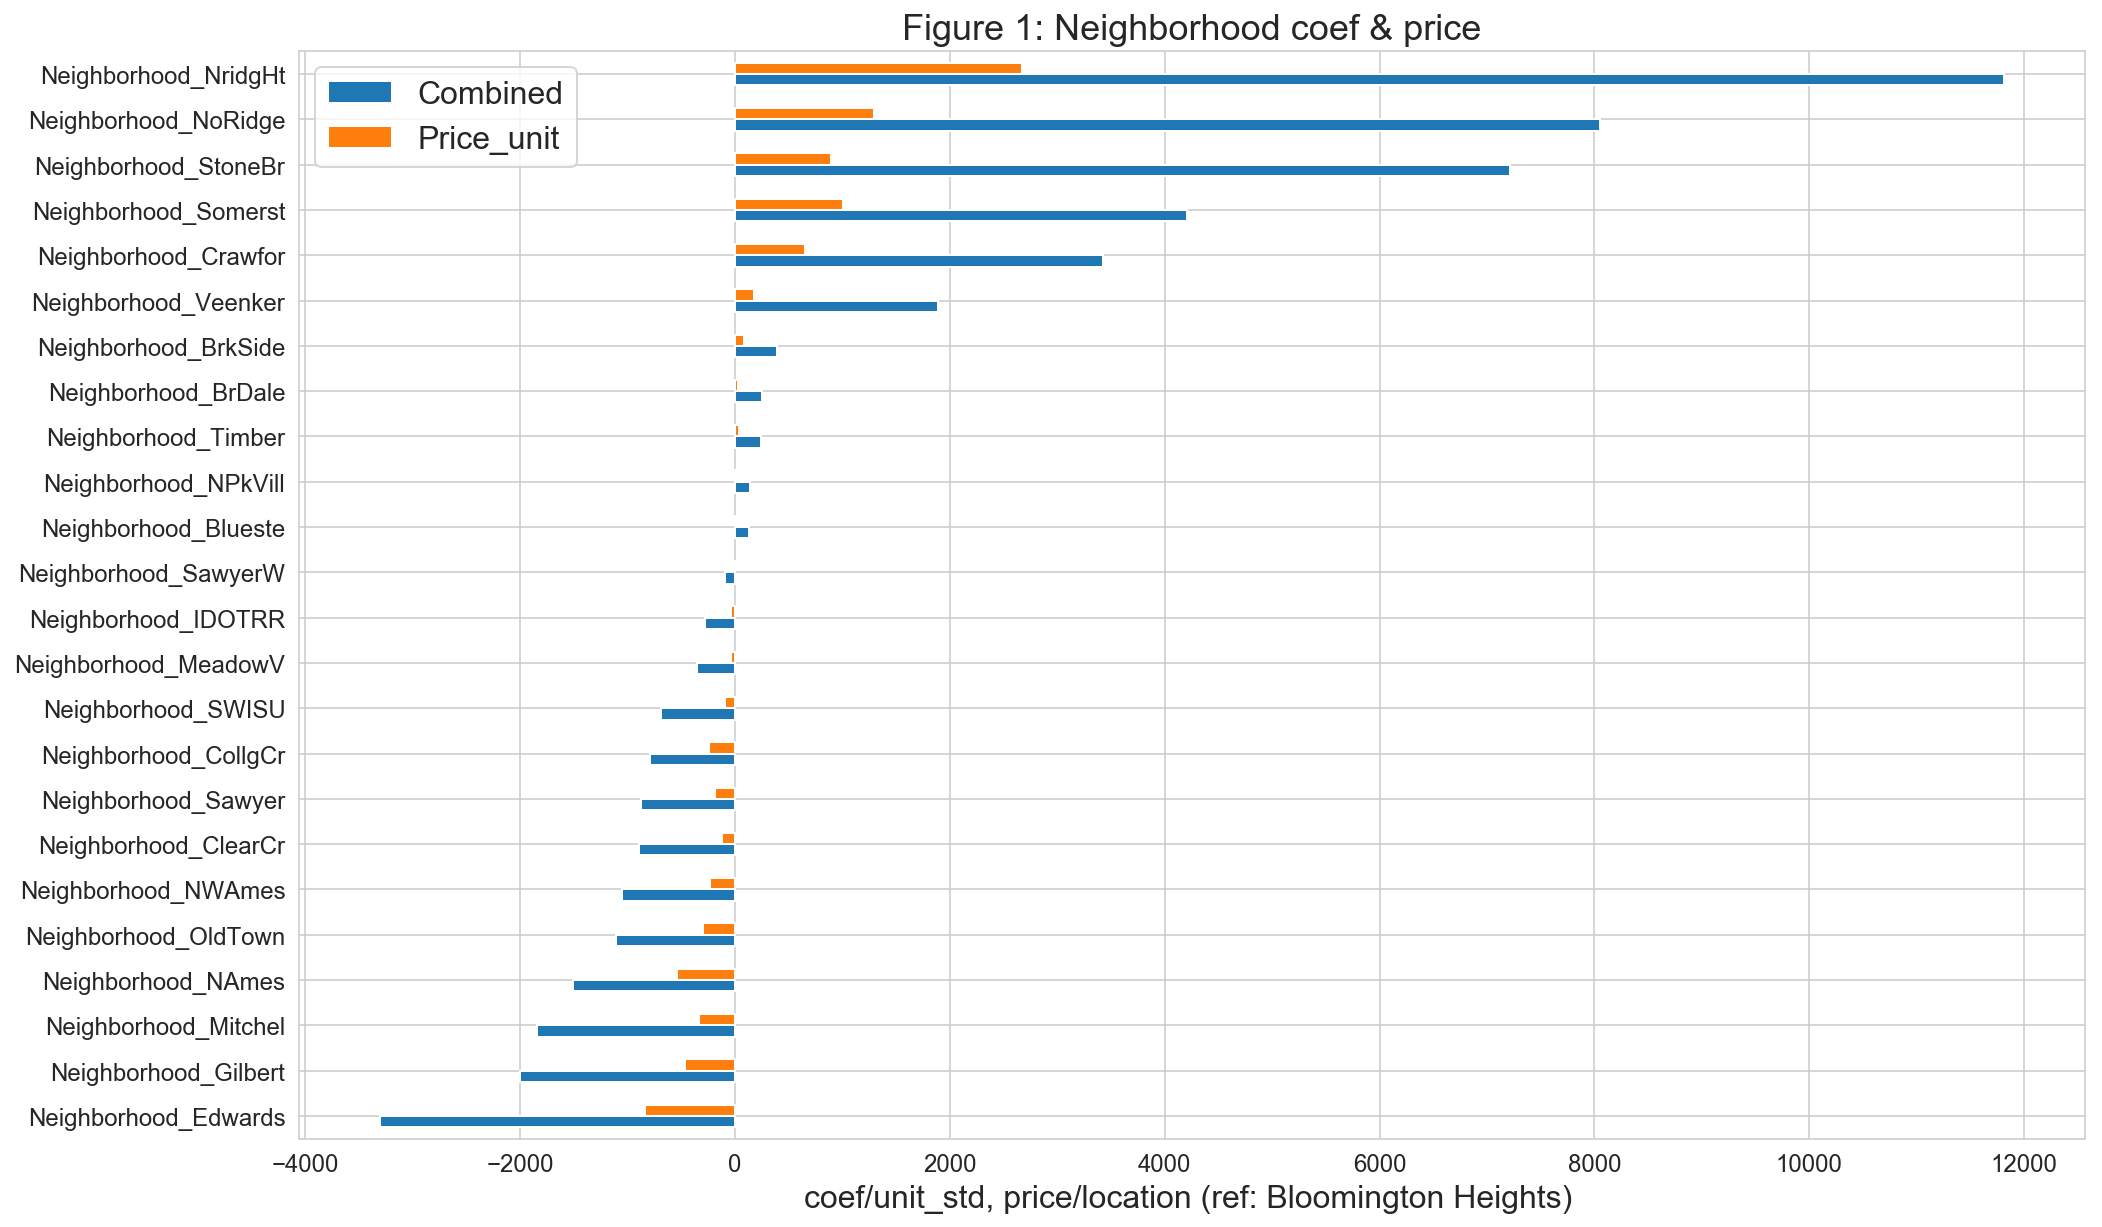

In [92]:
# Neighborhood
neigh_col = [index for index in combined_model_coef.index if 'Neighborhood' in index ]
ax = combined_model_coef.loc[neigh_col,:].sort_values(by='Combined').plot(kind='barh' )
plt.gcf().set_size_inches(16,10)
plt.title('Figure 1: Neighborhood coef & price', fontsize=18)
ax.tick_params(labelsize=12)
plt.legend(prop={'size': 16})
ax.set_xlabel('coef/unit_std, price/location (ref: Bloomington Heights) ',size=16)

Text(0.5, 0, 'coef/unit_std, price/type (ref:Average Exposure)')

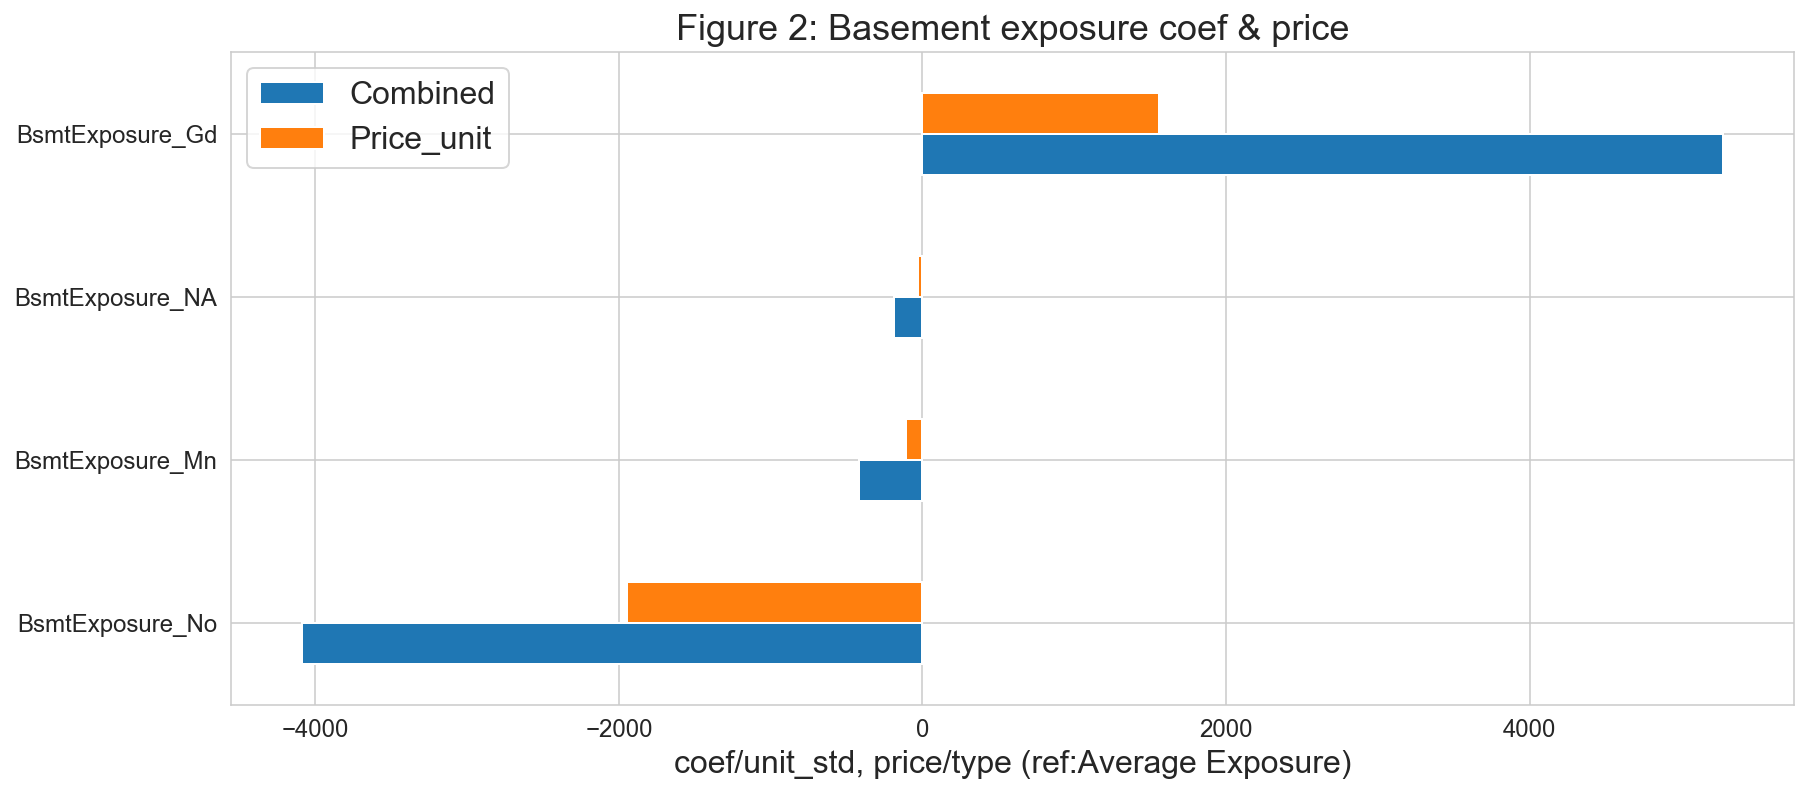

In [93]:
# BsmtExposure
bsmtE_col = [index for index in combined_model_coef.index if 'BsmtExposure' in index ]
ax = combined_model_coef.loc[bsmtE_col,:].sort_values(by='Combined').plot(kind='barh' )
plt.gcf().set_size_inches(14,6)
plt.title('Figure 2: Basement exposure coef & price', fontsize=18)
ax.tick_params(labelsize=12)
plt.legend(prop={'size': 16})
ax.set_xlabel('coef/unit_std, price/type (ref:Average Exposure)',size=16)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## The residual of fixed characters prediction

In [94]:
y_residual_train = y_train - combined_predict_train
y_residual_test = y_test - combined_predict_test

In [95]:
# absolute redisdual for training set
print(f" Training set absolute residual mean: {np.mean(abs(y_residual_train))} dollar, std: {np.std(y_residual_train)}")
# absolute redisdual for testing set
print(f" Testing set absolute residual mean: {np.mean(abs(y_residual_test))} dollar, std: {np.std(y_residual_test)}")


 Training set absolute residual mean: 18965.206257688198 dollar, std: 31655.29779315148
 Testing set absolute residual mean: 19339.551318347527 dollar, std: 29386.67883185762


Text(0.5, 0, 'Price difference')

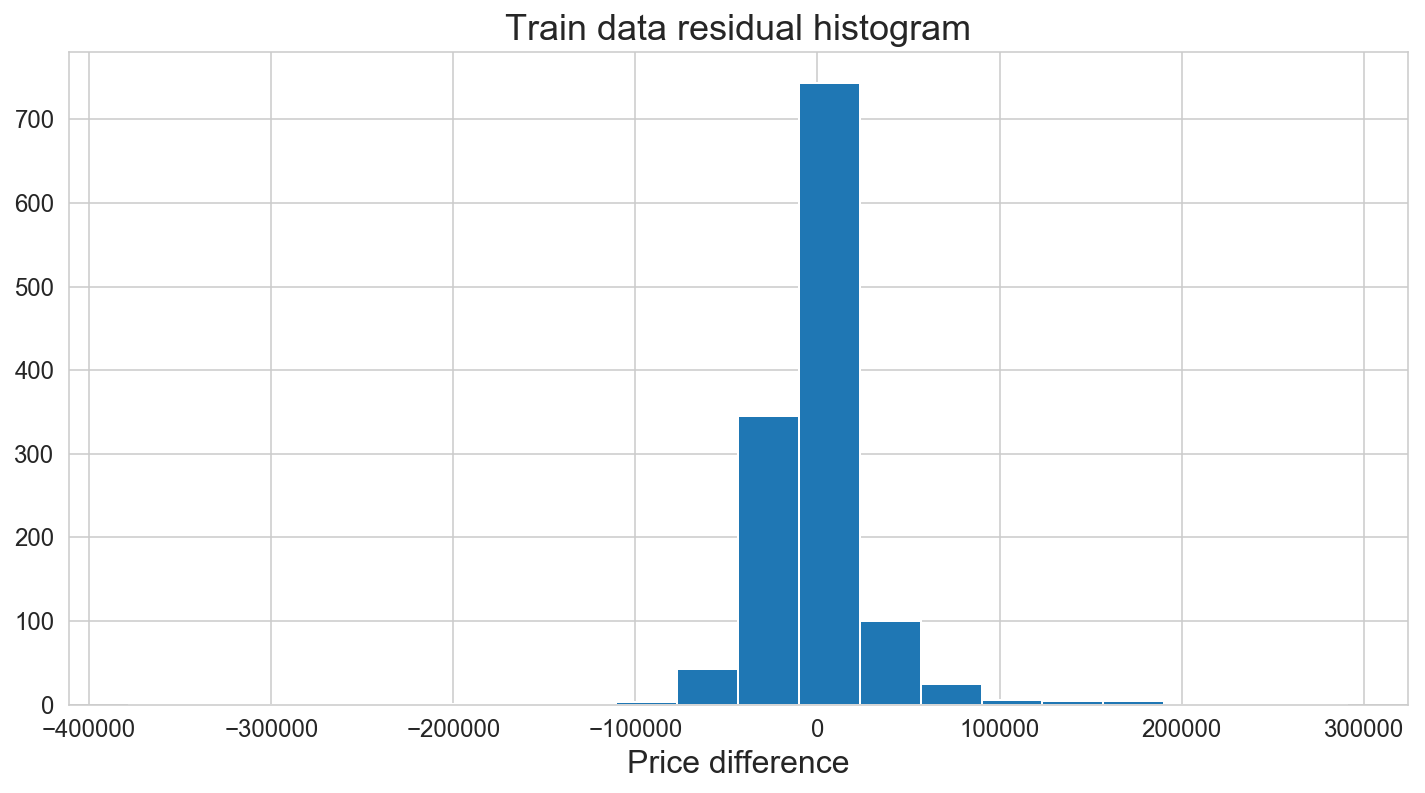

In [96]:
plt.hist(y_residual_train, bins=20);
plt.gcf().set_size_inches(12,6)
plt.title('Train data residual histogram', fontsize=18)
plt.gca().tick_params(labelsize=12)

plt.gca().set_xlabel('Price difference',size=16)

In [97]:
np.mean(abs(y_residual_test)), np.std(y_residual_test)

(19339.551318347527, 29386.67883185762)

Text(0.5, 0, 'Price difference')

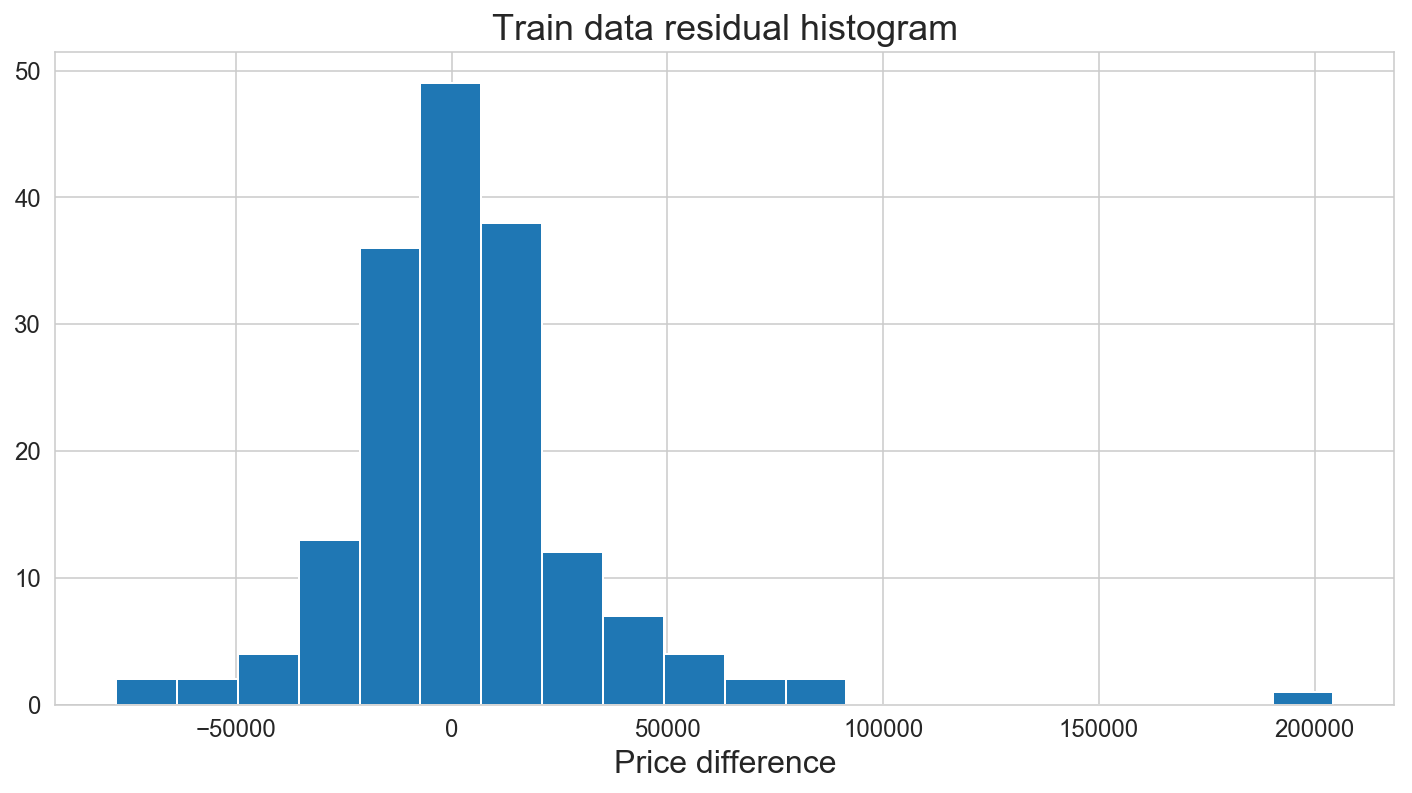

In [98]:
plt.hist(y_residual_test, bins=20);
plt.gcf().set_size_inches(12,6)
plt.title('Train data residual histogram', fontsize=18)
plt.gca().tick_params(labelsize=12)

plt.gca().set_xlabel('Price difference',size=16)

In [99]:
# select renovate-able characters
reno_ch = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating',
         'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu',  'GarageFinish',
         'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

In [100]:
# reminding factor is:
 [col for col in rest_ch if col not in reno_ch]

# Not selected because of redundant info or feature engineering:
# 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
# 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'

# Not selected because of not building charactor:
# 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'


['YearBuilt',
 'YearRemodAdd',
 '1stFlrSF',
 '2ndFlrSF',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [101]:
# For training set
reno_predictor = train_data[reno_ch]

# convert all categorical data and MSsubClass as dummies
object_col = [col for col in reno_ch if reno_predictor[col].dtype==object]
object_col.extend(['OverallQual', 'OverallCond'])
dummy_col = [col for col in object_col if col not in ['BsmtFinType1', 'BsmtFinType2']]
X_train_q2 = pd.get_dummies(reno_predictor, columns=dummy_col, drop_first=True)

# handle 'BsmtFinType1', 'BsmtFinType2' separately, to get type1 type2 size as value

X_train_q2 = pd.get_dummies(X_train_q2, columns=['BsmtFinType1', 'BsmtFinType2'], drop_first=False)
X_train_q2.drop(columns=['BsmtFinType1_NA', 'BsmtFinType2_NA'], inplace=True)
BsmtFinType1_col = [col for col in X_train_q2.columns if 'BsmtFinType1' in col]
BsmtFinType2_col = [col for col in X_train_q2.columns if 'BsmtFinType2' in col]

X_train_q2.loc[:,BsmtFinType1_col]= X_train_q2.loc[:,BsmtFinType1_col].apply(lambda x: x*X_train_q2.BsmtFinSF1)
X_train_q2.loc[:,BsmtFinType2_col]= X_train_q2.loc[:,BsmtFinType2_col].apply(lambda x: x*X_train_q2.BsmtFinSF2)
X_train_q2.drop(columns=['BsmtFinSF1','BsmtFinSF2'], inplace=True)
# no object datatype
np.argwhere(X_train_q2.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [102]:
# for testing set do the same

reno_predictor = test_data[reno_ch]
X_test_q2 = pd.get_dummies(reno_predictor, columns=dummy_col, drop_first=True)

# handle 'BsmtFinType1', 'BsmtFinType2' separately, to get type1 type2 size as value

X_test_q2 = pd.get_dummies(X_test_q2, columns=['BsmtFinType1', 'BsmtFinType2'], drop_first=False)
X_test_q2.drop(columns=['BsmtFinType1_NA', 'BsmtFinType2_NA'], inplace=True)
BsmtFinType1_col = [col for col in X_test_q2.columns if 'BsmtFinType1' in col]
BsmtFinType2_col = [col for col in X_test_q2.columns if 'BsmtFinType2' in col]

X_test_q2.loc[:,BsmtFinType1_col]= X_test_q2.loc[:,BsmtFinType1_col].apply(lambda x: x*X_test_q2.BsmtFinSF1)
X_test_q2.loc[:,BsmtFinType2_col]= X_test_q2.loc[:,BsmtFinType2_col].apply(lambda x: x*X_test_q2.BsmtFinSF2)
X_test_q2.drop(columns=['BsmtFinSF1','BsmtFinSF2'], inplace=True)


# no object
np.argwhere(X_test_q2.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [103]:
# size of training and testing does not match
X_train_q2.shape, y_residual_train.shape, X_test_q2.shape, y_residual_test.shape, 

((1278, 136), (1278,), (172, 97), (172,))

In [104]:
# there are categoies do not exist in testing data
missing_col = [col for col in X_train_q2.columns if col not in X_test_q2.columns]
missing_col

['RoofStyle_Gable',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShngl',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_CBlock',
 'Exterior2nd_Other',
 'Exterior2nd_Stone',
 'ExterCond_Fa',
 'BsmtCond_Po',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_OthW',
 'Heating_Wall',
 'HeatingQC_Po',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Functional_Maj2',
 'Functional_Min1',
 'Functional_Sev',
 'GarageQual_Fa',
 'GarageQual_Gd',
 'GarageQual_Po',
 'GarageCond_Fa',
 'GarageCond_Gd',
 'GarageCond_Po',
 'PoolQC_Fa',
 'PoolQC_Gd',
 'PoolQC_NA',
 'Fence_MnWw',
 'OverallQual_2',
 'OverallQual_3',
 'OverallQual_10',
 'OverallCond_2',
 'BsmtFinType2_othr']

In [105]:
# testing data do have additonal category than training data
[col for col in X_test_q2.columns if col not in X_train_q2.columns]

['Exterior1st_AsphShn', 'ExterCond_Po']

In [106]:
# Drop the columns that does not appared in the training data
X_test_q2.drop(columns=[col for col in X_test_q2.columns if col not in X_train_q2.columns], inplace=True)


In [107]:
# finding the missing columns
missing_col_loc = [np.argwhere(X_train_q2.columns==col)[0,0] for col in missing_col]

In [108]:
# size of training and testing does not match
X_train_q2.shape, y_residual_train.shape, X_test_q2.shape, y_residual_test.shape, 

((1278, 136), (1278,), (172, 95), (172,))

In [109]:
len(missing_col_loc)

41

In [110]:
list(enumerate(X_train_q2.columns))

[(0, 'BsmtUnfSF'),
 (1, 'LowQualFinSF'),
 (2, 'RoofStyle_Gable'),
 (3, 'RoofStyle_Gambrel'),
 (4, 'RoofStyle_Hip'),
 (5, 'RoofStyle_Mansard'),
 (6, 'RoofStyle_Shed'),
 (7, 'RoofMatl_CompShg'),
 (8, 'RoofMatl_Membran'),
 (9, 'RoofMatl_Metal'),
 (10, 'RoofMatl_Roll'),
 (11, 'RoofMatl_Tar&Grv'),
 (12, 'RoofMatl_WdShake'),
 (13, 'RoofMatl_WdShngl'),
 (14, 'Exterior1st_BrkComm'),
 (15, 'Exterior1st_BrkFace'),
 (16, 'Exterior1st_CBlock'),
 (17, 'Exterior1st_CemntBd'),
 (18, 'Exterior1st_HdBoard'),
 (19, 'Exterior1st_ImStucc'),
 (20, 'Exterior1st_MetalSd'),
 (21, 'Exterior1st_Plywood'),
 (22, 'Exterior1st_Stone'),
 (23, 'Exterior1st_Stucco'),
 (24, 'Exterior1st_VinylSd'),
 (25, 'Exterior1st_Wd Sdng'),
 (26, 'Exterior1st_WdShing'),
 (27, 'Exterior2nd_AsphShn'),
 (28, 'Exterior2nd_Brk Cmn'),
 (29, 'Exterior2nd_BrkFace'),
 (30, 'Exterior2nd_CBlock'),
 (31, 'Exterior2nd_CmentBd'),
 (32, 'Exterior2nd_HdBoard'),
 (33, 'Exterior2nd_ImStucc'),
 (34, 'Exterior2nd_MetalSd'),
 (35, 'Exterior2nd_Other'),

In [111]:
# fillin zeros for the missing columns
for i,locnumber in enumerate(missing_col_loc):
    X_test_q2.insert(loc=int(locnumber), column=missing_col[i], value=[0 for ele in range(X_test_q2.shape[0])])

In [112]:
# size of training and testing does match
X_train_q2.shape, y_residual_train.shape, X_test_q2.shape, y_residual_test.shape, 

((1278, 136), (1278,), (172, 136), (172,))

In [113]:
# column order is correct now
list(enumerate(X_train_q2.columns)) == list(enumerate(X_test_q2.columns))

True

## Train and validate

In [114]:
# model 1 LinearRegression
# very bad, will not take into consideration
scaler2 = StandardScaler()
lr = LinearRegression()
X_train_std_q2 = scaler2.fit_transform(X_train_q2)
score1_q2 = cross_val_score(lr, X_train_std_q2, y_residual_train, scoring='r2', cv=10)
np.mean(score1_q2), np.std(score1_q2)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(-1.8469782699309483e+24, 4.2716378027903721e+24)

In [115]:
# transfer the test data
X_test_std_q2 = scaler2.transform(X_test_q2)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [116]:
# # model 2 Lasso
# # using Lasso model to remove features not important
# # The CV score mean is 0.10290740265235394, the CV score std is 0.25429595160165347
# # residual fitting 0.23381648151635384
# # price fitting 0.89592310132732189 

# lassoCV2 = LassoCV(alphas=np.linspace(1100, 1250, 800), random_state=42, cv=10, max_iter=5000)
# lassoCV2.fit(X_train_std_q2, y_residual_train)
# print(f'alpha is {lassoCV2.alpha_}')
# lasso_q2 = Lasso(alpha=lassoCV2.alpha_, random_state=42, max_iter=5000)


In [117]:
score2_q2 = cross_val_score(lasso_q2, X_train_std_q2, y_residual_train, scoring='r2', cv=10)
print(f"The CV score mean is {np.mean(score2_q2)}, the CV score std is {np.std(score2_q2)}")
lasso_q2.fit(X_train_std_q2,y_residual_train)
lasso_q2.score(X_test_std_q2,y_residual_test)

The CV score mean is 0.10290740265235394, the CV score std is 0.25429595160165347


0.23381648151635384

In [118]:
errors = y_test - (lasso_q2.predict(X_test_std_q2) + lasso.predict(X_test_std))

In [119]:
r2_score(y_test, lasso_q2.predict(X_test_std_q2) + combined_predict_test)

0.89592310132732189

In [120]:
# append result
Score_method_q2 = pd.DataFrame()

Score_method_q2.loc["CV_train_score", "Lasso"] = np.mean(score2_q2)
Score_method_q2.loc["Test_score", "Lasso"] = lasso_q2.score(X_test_std_q2,y_residual_test)
Score_method_q2.loc["Overall_Test_score", "Lasso"]  = r2_score(y_test, lasso_q2.predict(X_test_std_q2) + combined_predict_test)

In [121]:
# add coef to feature df
Feature_coef_q2 = pd.DataFrame(data=lasso_q2.coef_, index=X_train_q2.columns, columns=['Lasso'])
Feature_coef_q2.loc['Intercept', 'Lasso'] = lasso_q2.intercept_
Feature_coef_q2.iloc[np.argsort(Feature_coef_q2.Lasso.abs())[::-1]].head(64)

,Lasso
OverallQual_9,6.877697e+03
OverallQual_10,6.047959e+03
PoolQC_Gd,-4.344934e+03
RoofMatl_WdShngl,3.902259e+03
Exterior1st_BrkFace,2.708481e+03
Functional_Typ,2.573065e+03
OverallQual_8,2.012204e+03
OverallCond_5,-1.739917e+03
OverallCond_3,-1.726240e+03
BsmtUnfSF,-1.403375e+03


In [122]:
# # model 3 ridge 
# # The CV score mean 0.10326690449006218, the CV score std 0.22335741500638728
# # Residual fitting score: 0.19151559370456128
# # Test score 0.89017702991186609

# ridgeCV_q2 = RidgeCV(alphas=np.linspace(700, 1200, 400), cv=10,scoring='r2')
# ridgeCV_q2.fit(X_train_std_q2, y_residual_train)
# print(f'alpha is {ridgeCV_q2.alpha_}')
# ridge_q2 = Ridge(alpha=ridgeCV_q2.alpha_,random_state=42, max_iter=5000)

In [123]:
score3_q2 = cross_val_score(ridge,X_train_std_q2, y_residual_train, scoring='r2', cv=10)
print(f"The CV score mean {np.mean(score3_q2)}, the CV score std {np.std(score3_q2)}")
ridge_q2.fit(X_train_std_q2,y_residual_train)
ridge_q2.score(X_test_std_q2, y_residual_test)

The CV score mean 0.10326690449006218, the CV score std 0.22335741500638728


0.19151559370456128

In [124]:
r2_score(y_test,ridge_q2.predict(X_test_std_q2) + combined_predict_test)

0.89017702991186609

In [125]:
Score_method_q2.loc["CV_train_score", "Ridge"] = np.mean(score3_q2)
Score_method_q2.loc["Test_score", "Ridge"] = ridge_q2.score(X_test_std_q2, y_residual_test)
Score_method_q2.loc["Overall_Test_score", "Ridge"] = r2_score(y_test,ridge_q2.predict(X_test_std_q2) + combined_predict_test)

In [126]:
# add Ridge coef
Feature_coef_q2.loc[:-1,'Ridge'] = ridge_q2.coef_
Feature_coef_q2.loc['Intercept','Ridge'] = ridge_q2.intercept_
Feature_coef_q2.iloc[np.argsort(Feature_coef_q2.Ridge.abs())[::-1]].head(20)

,Lasso,Ridge
OverallQual_9,6877.697336,3357.146649
RoofMatl_WdShngl,3902.259337,3161.237639
OverallQual_10,6047.958761,3067.959639
PoolQC_Gd,-4344.934018,-2880.954993
BsmtQual_Gd,-1195.460013,-1840.548109
Exterior1st_BrkFace,2708.480749,1622.152449
OverallCond_3,-1726.239814,-1463.277049
Functional_Typ,2573.064926,1412.645183
KitchenQual_Gd,-0.000000,-1324.380361
OverallCond_7,1213.540299,1289.353845


In [127]:
# # model 4 elasticNet

# # The CV score mean  0.13914186019151875, the CV score std 0.1303704813385505
# # Residual fitting score is 0.19112224683980972
# # Price fitting score is 0.89012359842867916

l1_ratios=np.linspace(0.001, 1, 100)
n_alpha = 1000

# elasticNetCV_q2 = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=n_alpha, cv=10, max_iter=5000, random_state=42)
# elasticNetCV_q2.fit(X_train_std_q2, y_residual_train)

# print(f"The l1 ration is {elasticNetCV_q2.l1_ratio_}, the alpha is {elasticNetCV_q2.alpha_}")
# elasticNet_q2 = ElasticNet(alpha=elasticNetCV_q2.alpha_, l1_ratio=elasticNetCV_q2.l1_ratio_, max_iter=5000)


In [128]:
score4_q2 = cross_val_score(elasticNet_q2,X_train_std_q2, y_residual_train, scoring='r2', cv=10)
print(f"The CV score mean {np.mean(score4_q2)}, the CV score std {np.std(score4_q2)}")

elasticNet_q2.fit(X_train_std_q2, y_residual_train)

elasticNet_q2.score(X_test_std_q2, y_residual_test)

The CV score mean 0.13914186019151875, the CV score std 0.1303704813385505


0.19112224683980972

In [129]:
r2_score(y_test, elasticNet_q2.predict(X_test_std_q2) + combined_predict_test)

0.89012359842867916

In [130]:
Score_method_q2.loc["CV_train_score", "ElasticNet"] = np.mean(score4_q2)
Score_method_q2.loc["Test_score", "ElasticNet"] = elasticNet_q2.score(X_test_std_q2, y_residual_test)
Score_method_q2.loc["Overall_Test_score", "ElasticNet"] = r2_score(y_test, elasticNet_q2.predict(X_test_std_q2) + combined_predict_test)

In [131]:
# add ElasticNet coef
Feature_coef_q2.loc[:-1,'ElasticNet'] = elasticNet_q2.coef_
Feature_coef_q2.loc['Intercept','ElasticNet'] = elasticNet_q2.intercept_
Feature_coef_q2.iloc[np.argsort(Feature_coef_q2.ElasticNet.abs())[::-1]].head(20)

,Lasso,Ridge,ElasticNet
OverallQual_9,6877.697336,3357.146649,3250.059324
RoofMatl_WdShngl,3902.259337,3161.237639,2987.644552
OverallQual_10,6047.958761,3067.959639,2965.321775
PoolQC_Gd,-4344.934018,-2880.954993,-2693.969466
BsmtQual_Gd,-1195.460013,-1840.548109,-1716.759421
Exterior1st_BrkFace,2708.480749,1622.152449,1560.255849
Functional_Typ,2573.064926,1412.645183,1394.808188
OverallCond_3,-1726.239814,-1463.277049,-1386.322335
OverallCond_7,1213.540299,1289.353845,1209.036745
KitchenQual_Gd,-0.000000,-1324.380361,-1183.288179


In [132]:
# # model 5 SelectKBest + LinearRegression
# # The CV score is 0.15155782133445592
# # Residual fitting score is 0.20546664277538462
# # Price fitting score is 0.8920721136424522
# # The best parameters are {'KB__k': 91, 'KB__score_func': <function mutual_info_regression at 0x000002918D6E2510>}

# pipeline_KB_LR_q2 = Pipeline([("KB", SelectKBest()), ("LR", LinearRegression())])

# print(f"Hyperparameter: {pipeline_KB_LR_q2.get_params().keys()}")

# KB_LR_parameter_q2 = {"KB__k": list(range(1,100)),
#                   "KB__score_func": [f_regression, mutual_info_regression]}

# KB_LR_q2 = GridSearchCV(pipeline_KB_LR_q2, KB_LR_parameter_q2, cv=5, scoring="r2", n_jobs=7)
# KB_LR_q2.fit(X_train_std_q2, y_residual_train)

In [133]:
print(f"The best parameters are {KB_LR_q2.best_params_}")
print(f"The CV score is {KB_LR_q2.best_score_}")
KB_lR_predict_q2 = KB_LR_q2.predict(X_test_std_q2)
r2_score(y_residual_test, KB_lR_predict_q2)

The best parameters are {'KB__k': 25, 'KB__score_func': <function f_regression at 0x0000020B8555F7B8>}
The CV score is 0.15155782133445592


0.20546664277538462

In [134]:
r2_score(y_test, KB_LR_q2.predict(X_test_std_q2) + combined_predict_test)

0.8920721136424522

In [135]:
Score_method_q2.loc["CV_train_score", "KBest_LR"] = KB_LR_q2.best_score_
Score_method_q2.loc["Test_score", "KBest_LR"] = r2_score(y_residual_test, KB_lR_predict_q2)
Score_method_q2.loc["Overall_Test_score", "KBest_LR"]  = r2_score(y_test, KB_LR_q2.predict(X_test_std_q2) + combined_predict_test)

In [136]:
Score_method_q2

,Lasso,Ridge,ElasticNet,KBest_LR
CV_train_score,0.102907,0.103267,0.139142,0.151558
Test_score,0.233816,0.191516,0.191122,0.205467
Overall_Test_score,0.895923,0.890177,0.890124,0.892072


In [137]:
# add the feature coef
Feature_coef_q2.loc[:,'KBest_LR']=0
kb_col = X_train_q2.columns[KB_LR_q2.best_estimator_.named_steps['KB'].get_support()]
Feature_coef_q2.loc[kb_col,'KBest_LR']=KB_LR_q2.best_estimator_.named_steps['LR'].coef_
Feature_coef_q2.loc['Intercept','KBest_LR']=KB_LR_q2.best_estimator_.named_steps['LR'].intercept_
Feature_coef_q2.iloc[np.argsort(Feature_coef_q2.KBest_LR.abs())[::-1]].head(20)

,Lasso,Ridge,ElasticNet,KBest_LR
OverallQual_9,6877.697336,3357.146649,3250.059324,7283.689442
OverallQual_10,6047.958761,3067.959639,2965.321775,6574.473676
PoolQC_Gd,-4344.934018,-2880.954993,-2693.969466,-5813.363835
RoofMatl_WdShngl,3902.259337,3161.237639,2987.644552,4582.835701
RoofStyle_Gable,-0.000000,-674.896653,-654.007904,-4064.023665
Exterior1st_BrkFace,2708.480749,1622.152449,1560.255849,3973.264831
RoofStyle_Hip,0.000000,502.397624,493.866080,-3681.382451
Functional_Typ,2573.064926,1412.645183,1394.808188,3550.199545
BsmtQual_Gd,-1195.460013,-1840.548109,-1716.759421,-3410.304024
OverallCond_7,1213.540299,1289.353845,1209.036745,2998.612151


In [138]:
# # model 6 rfe+linearRegression
# # The CV score is 0.010912596509352373
# # The residual fitting score is -0.035459526335483993
# # The price fitting score is 0.8593451652218258
# rfeCV_q2 = RFE(LinearRegression())

# rfeCV_parameters_q2 = {"n_features_to_select": range(1,100),
#               "step": range(1,6) 
# }

# RFECV_GS_q2 = GridSearchCV(rfeCV_q2, rfeCV_parameters_q2, cv=5, scoring="r2", n_jobs=7 )
# RFECV_GS_q2.fit(X_train_std_q2, y_residual_train)

In [139]:
print(f"The best parameters are {RFECV_GS_q2.best_params_}")
print(f"The CV score is {RFECV_GS_q2.best_score_}")
RFECV_GS_predict_q2 = RFECV_GS_q2.predict(X_test_std_q2)
r2_score(y_residual_test, RFECV_GS_predict_q2)

The best parameters are {'n_features_to_select': 2, 'step': 4}
The CV score is 0.010912596509352373


-0.035459526335483993

In [140]:
r2_score(y_test, RFECV_GS_q2.predict(X_test_std_q2) + combined_predict_test)

0.8593451652218258

In [141]:
Score_method_q2.loc["CV_train_score", "RFE_LR"] = RFECV_GS_q2.best_score_
Score_method_q2.loc["Test_score", "RFE_LR"] = r2_score(y_residual_test, RFECV_GS_predict_q2)
Score_method_q2.loc["Overall_Test_score", "RFE_LR"] = r2_score(y_test, RFECV_GS_q2.predict(X_test_std_q2) + combined_predict_test)

In [142]:
# # storing model
# pickle.dump( [ KB_LR_q2, elasticNet_q2, ridge_q2, lasso_q2], open( "save_result_q2_part.p", "wb" ) )
# pickle.dump( [RFECV_GS_q2], open( "save_result_q2_RFECV.p", "wb" ) )

In [143]:
Feature_coef_q2.loc[:,'RFE_LR']=0
kb_col = X_train_q2.columns[RFECV_GS_q2.best_estimator_.support_]
Feature_coef_q2.loc[kb_col,'RFE_LR']=RFECV_GS_q2.best_estimator_.estimator_.coef_
Feature_coef_q2.loc['Intercept','RFE_LR']=RFECV_GS_q2.best_estimator_.estimator_.intercept_
Feature_coef_q2.iloc[np.argsort(Feature_coef_q2.RFE_LR.abs())[::-1]].head(20)

,Lasso,Ridge,ElasticNet,KBest_LR,RFE_LR
OverallCond_7,1.213540e+03,1.289354e+03,1.209037e+03,2.998612e+03,2.675040e+03
OverallCond_6,0.000000e+00,7.418614e+02,6.483232e+02,0.000000e+00,1.220984e+03
Intercept,-9.825951e-12,-1.016932e-11,-1.005198e-11,-8.771093e-12,-9.661173e-12
HeatingQC_Po,-0.000000e+00,-1.746830e+02,-1.038947e+02,0.000000e+00,0.000000e+00
HeatingQC_Gd,-0.000000e+00,-5.254731e+02,-4.480524e+02,0.000000e+00,0.000000e+00
Exterior2nd_Other,-0.000000e+00,-3.229518e+02,-2.634901e+02,0.000000e+00,0.000000e+00
Exterior2nd_Plywood,-0.000000e+00,-2.230342e+02,-2.009778e+02,0.000000e+00,0.000000e+00
Exterior2nd_Stone,-0.000000e+00,-3.552997e+02,-2.767156e+02,0.000000e+00,0.000000e+00
Exterior2nd_Stucco,-4.829145e+02,-8.051844e+02,-7.307186e+02,0.000000e+00,0.000000e+00
Exterior2nd_VinylSd,0.000000e+00,4.067950e+01,0.000000e+00,0.000000e+00,0.000000e+00


## Model selection

In [144]:
Score_method_q2

,Lasso,Ridge,ElasticNet,KBest_LR,RFE_LR
CV_train_score,0.102907,0.103267,0.139142,0.151558,0.010913
Test_score,0.233816,0.191516,0.191122,0.205467,-0.035460
Overall_Test_score,0.895923,0.890177,0.890124,0.892072,0.859345


In [145]:
combined_predict_q2 = (lasso_q2.predict(X_test_std_q2)*Score_method_q2.loc["Test_score", "Lasso"] 
                    + KB_LR_q2.predict(X_test_std_q2)*Score_method_q2.loc["Test_score", "KBest_LR"]
                     )/Score_method_q2.loc['Test_score',['Lasso','KBest_LR']].sum()
r2_score(y_residual_test, combined_predict_q2)

0.24244980746937939

In [146]:
r2_score(y_test, combined_predict_q2 + combined_predict_test)

0.89709583575549068

In [147]:
# combined coef
combined_predict_coef_q2 = (Feature_coef_q2.loc[:, "Lasso"] *Score_method_q2.loc["Test_score", "Lasso"] 
                        + Feature_coef_q2.loc[:, "KBest_LR"]*Score_method_q2.loc["Test_score", "KBest_LR"])/Score_method_q2.loc['Test_score',['Lasso','KBest_LR']].sum()
Feature_coef_q2.loc[:,'Combined'] = combined_predict_coef_q2
Feature_coef_q2.iloc[np.argsort(Feature_coef_q2.Combined.abs())[::-1]].head(30)

,Lasso,Ridge,ElasticNet,KBest_LR,RFE_LR,Combined
OverallQual_9,6877.697336,3357.146649,3250.059324,7283.689442,0.000000,7067.592714
OverallQual_10,6047.958761,3067.959639,2965.321775,6574.473676,0.000000,6294.226478
PoolQC_Gd,-4344.934018,-2880.954993,-2693.969466,-5813.363835,0.000000,-5031.765194
RoofMatl_WdShngl,3902.259337,3161.237639,2987.644552,4582.835701,0.000000,4220.586477
Exterior1st_BrkFace,2708.480749,1622.152449,1560.255849,3973.264831,0.000000,3300.060358
Functional_Typ,2573.064926,1412.645183,1394.808188,3550.199545,0.000000,3030.101763
OverallQual_8,2012.203972,858.234135,792.627321,2868.766844,0.000000,2412.845580
BsmtQual_Gd,-1195.460013,-1840.548109,-1716.759421,-3410.304024,0.000000,-2231.412769
OverallCond_3,-1726.239814,-1463.277049,-1386.322335,-2655.157897,0.000000,-2160.724248
OverallCond_7,1213.540299,1289.353845,1209.036745,2998.612151,2675.040432,2048.474992


In [148]:
# finally choose the combined model
combined_predict_test_q2 = (combined_predict_coef_q2[:-1].dot(X_test_std_q2.T)+combined_predict_coef_q2[-1])
combined_predict_train_q2 = (combined_predict_coef_q2[:-1].dot(X_train_std_q2.T)+combined_predict_coef_q2[-1])

### Choosing Lasso + KB_LR weighted model as finall result for question 2, review of the second model and the improvement

1. The model fitting R2 score **y_residual_q1 ~ renovate-able factor** is: 0.24244980746937939
2. The overall model fitting R2 score **y_total_price ~ fixed factor prediction + renovate-able factor prediction** is 0.8970958357554907
3. The overall model fitting R2 score improved by 0.03453380150565244
4. Mean absolute error: 
    - Testing set remining Absolute error mean :  17997.420483400467  std: 18174.039103185718
    - Training set remining Absolute error mean : 16674.198312624303  std: 21439.98738663159
    - Testing set q1 Absolute error mean : 19339.551318347527  std: 22354.636093503184
    - Training set q1 Absolute error mean : 18965.206257688198  std: 25345.193429454142
5. Improve on price variance:
    - Testing set improve: 1342.13083494706 dollar
    - Traning set improve: 2291.007945063895 dollar
    



In [149]:
print(f"The residual fitting R2 score is: {r2_score(y_residual_test, combined_predict_q2)}")
print(f"The price fitting R2 score is {r2_score(y_test, combined_predict_q2 + combined_predict_test)}")
print(f"The price fitting R2 score improved by {r2_score(y_test, combined_predict_q2 + combined_predict_test) - r2_score(y_test, combined_predict)}")

print(f"Testing set remining Absolute error mean : {np.mean(abs(y_test-(combined_predict_test_q2 + combined_predict_test)))}",
      f" std: {np.std(abs(y_test-(combined_predict_test_q2 + combined_predict_test)))}",)
print(f"Training set remining Absolute error mean : {np.mean(abs(y_train-(combined_predict_train_q2 + combined_predict_train)))}",
      f" std: {np.std(abs(y_train-(combined_predict_train_q2 + combined_predict_train)))}",)
print(f"Testing set q1 Absolute error mean : {np.mean(abs(y_test-(combined_predict_test)))}",
      f" std: {np.std(abs(y_test-(combined_predict_test)))}",)
print(f"Training set q1 Absolute error mean : {np.mean(abs(y_train-( combined_predict_train)))}",
      f" std: {np.std(abs(y_train-(combined_predict_train)))}",)
print(f"Testing set improve: {np.mean(abs(y_test-( combined_predict_test))) - np.mean(abs(y_test-(combined_predict_test_q2 + combined_predict_test))) }")
print(f"Traning set improve: {np.mean(abs(y_train-( combined_predict_train))) - np.mean(abs(y_train-(combined_predict_train_q2 + combined_predict_train))) }")

The residual fitting R2 score is: 0.24244980746937939
The price fitting R2 score is 0.8970958357554907
The price fitting R2 score improved by 0.03453380150565244
Testing set remining Absolute error mean : 17997.420483400467  std: 18174.039103185718
Training set remining Absolute error mean : 16674.198312624303  std: 21439.98738663159
Testing set q1 Absolute error mean : 19339.551318347527  std: 22354.636093503184
Training set q1 Absolute error mean : 18965.206257688198  std: 25345.193429454142
Testing set improve: 1342.13083494706
Traning set improve: 2291.007945063895


## Model explain

In [150]:
# Dummy column reference:
# The Intercept almost zero is the average price of the refence house with:

dummy_col.extend(['BsmtFinType1', 'BsmtFinType2'])
[col +": " + str(sorted(house_residential[col].unique())[0]) for col in dummy_col]

['RoofStyle: Flat',
 'RoofMatl: ClyTile',
 'Exterior1st: AsbShng',
 'Exterior2nd: AsbShng',
 'ExterQual: Ex',
 'ExterCond: Ex',
 'BsmtQual: Ex',
 'BsmtCond: Fa',
 'Heating: Floor',
 'HeatingQC: Ex',
 'CentralAir: N',
 'Electrical: FuseA',
 'KitchenQual: Ex',
 'Functional: Maj1',
 'FireplaceQu: Ex',
 'GarageFinish: Fin',
 'GarageQual: Ex',
 'GarageCond: Ex',
 'PavedDrive: N',
 'PoolQC: Ex',
 'Fence: GdPrv',
 'OverallQual: 1',
 'OverallCond: 1',
 'BsmtFinType1: ALQ',
 'BsmtFinType2: ALQ']

### Most influence fixed characters

In [151]:
# convert the feature coef from price/std to price/(original unit of feature) 
combined_model_coef_q2 = Feature_coef_q2[['Combined']].copy()
combined_model_coef_q2['Price_unit'] = combined_model_coef_q2.apply(lambda x:x*X_train_q2.std()/(X_train_q2.max()-X_train_q2.min()))
combined_model_coef_q2.loc['Intercept','Price_unit'] = combined_model_coef_q2.loc['Intercept','Combined']
combined_model_coef_q2.iloc[np.argsort(combined_model_coef_q2.Combined.abs())[::-1]].head(40)

,Combined,Price_unit
OverallQual_9,7.067593e+03,1.185489e+03
OverallQual_10,6.294226e+03,7.419985e+02
PoolQC_Gd,-5.031765e+03,-2.435988e+02
RoofMatl_WdShngl,4.220586e+03,2.886231e+02
Exterior1st_BrkFace,3.300060e+03,5.748458e+02
Functional_Typ,3.030102e+03,7.594229e+02
OverallQual_8,2.412846e+03,7.813752e+02
BsmtQual_Gd,-2.231413e+03,-1.104001e+03
OverallCond_3,-2.160724e+03,-2.811542e+02
OverallCond_7,2.048475e+03,7.010903e+02


### Coef explained Top 10 coef
1. The high OverallQual house (10-Very Excellent, 9-Excellent, 8-Very Good) gives difference on the price around 700 to 1200 dollar (figure 1)
2. PoolQC gives difference between Excellent to good, about 243 dollars
3. Roof material: Wood Shingles give 288 dollar extra value, others do not affect
4. External material 1: Brick Face, Cement Board give difference to other material for 574, 310 dollar(figure 2)
5. Functional type give difference(figure 3), upto 760 to the reference type
6. BsmtQual is also important, pre sqft value difference between excellent condition and good condition is 1104 dollar.
7. Overall condition, give a range of difference on price(figure 4)
8. Roofstyle Gable & Hip gives less worth than reference Flat roof by 780 and 680 dollar
9. GarageFinish rough finish vs finish gives 445 dollar less value & ExterQual typical vs excellent about -466 dollar difference
10. FireplaceQu difference between exellent and Good is 361 dollar

##### Additional:  BsmtUnfSF per unit not in top 10, however, the result is compute pre unit, the -142 dollar/sqft. Consider basement size 500 sqft, it become a huge difference.



Text(0.5, 0, 'coef/unit_std, price/location (ref: OverallQual_1) ')

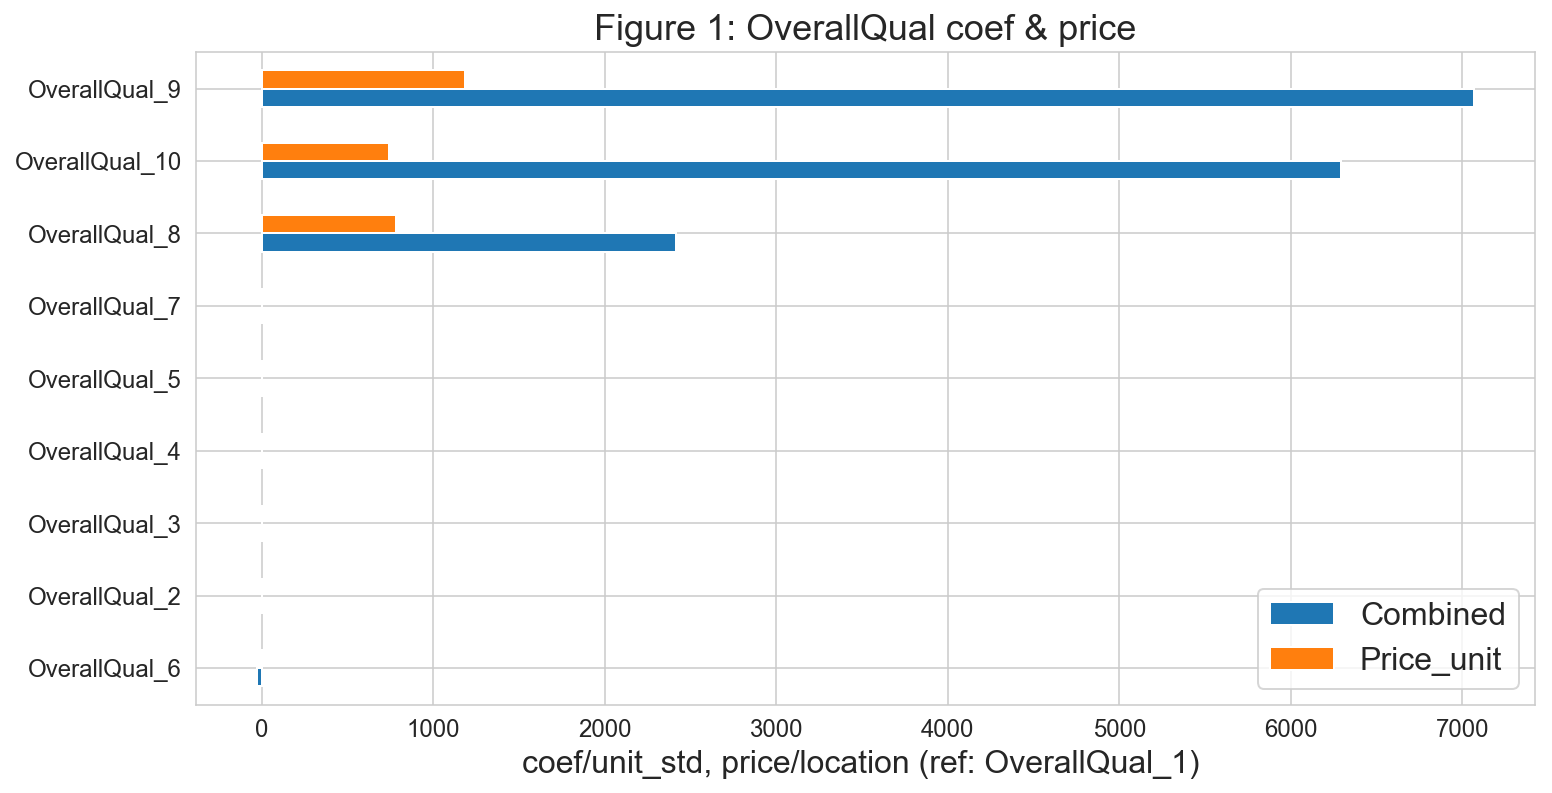

In [152]:
# OverallQual
neigh_col = [index for index in combined_model_coef_q2.index if 'OverallQual' in index ]
ax = combined_model_coef_q2.loc[neigh_col,:].sort_values(by='Combined').plot(kind='barh' )
plt.gcf().set_size_inches(12,6)
plt.title('Figure 1: OverallQual coef & price', fontsize=18)
ax.tick_params(labelsize=12)
plt.legend(prop={'size': 16})
ax.set_xlabel('coef/unit_std, price/location (ref: OverallQual_1) ',size=16)

Text(0.5, 0, 'coef/unit_std, price/location (ref: Exterior1st_AsbShng) ')

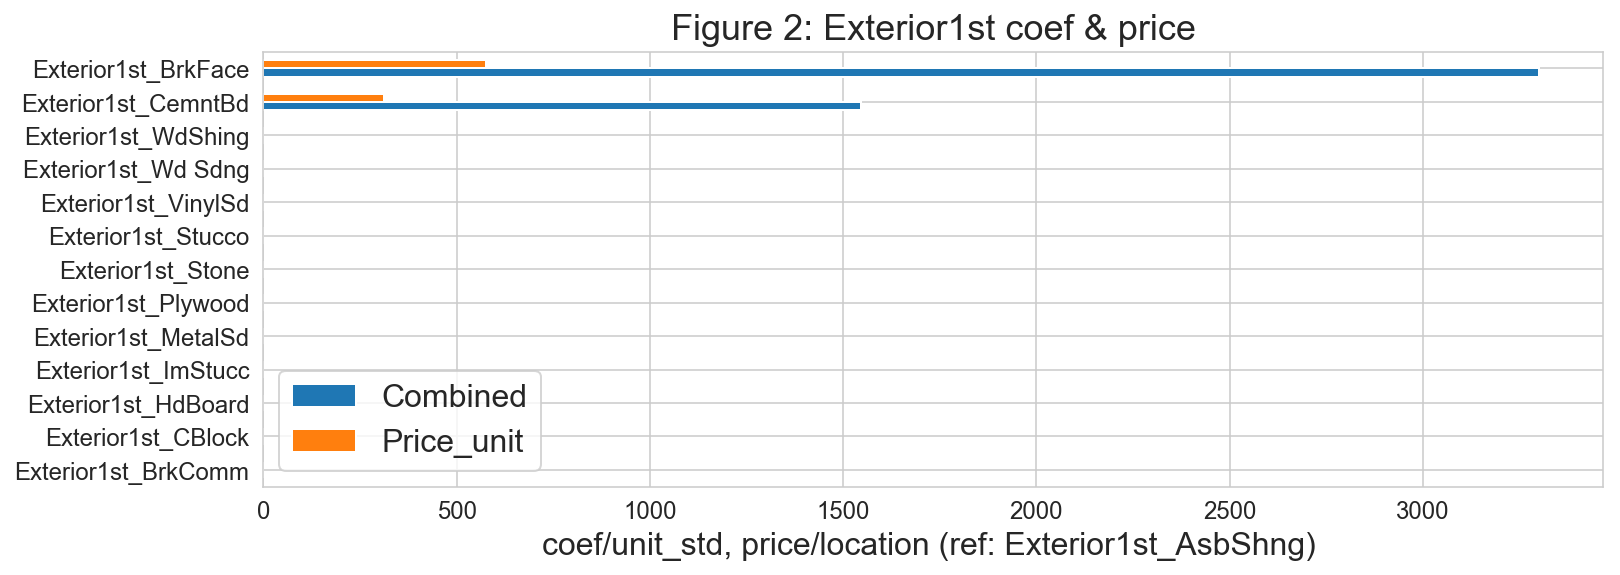

In [153]:
# Exterior1st
neigh_col = [index for index in combined_model_coef_q2.index if 'Exterior1st' in index ]
ax = combined_model_coef_q2.loc[neigh_col,:].sort_values(by='Combined').plot(kind='barh' )
plt.gcf().set_size_inches(12,4)
plt.title('Figure 2: Exterior1st coef & price', fontsize=18)
ax.tick_params(labelsize=12)
plt.legend(prop={'size': 16})
ax.set_xlabel('coef/unit_std, price/location (ref: Exterior1st_AsbShng) ',size=16)

Text(0.5, 0, 'coef/unit_std, price/location (ref: Maj1) ')

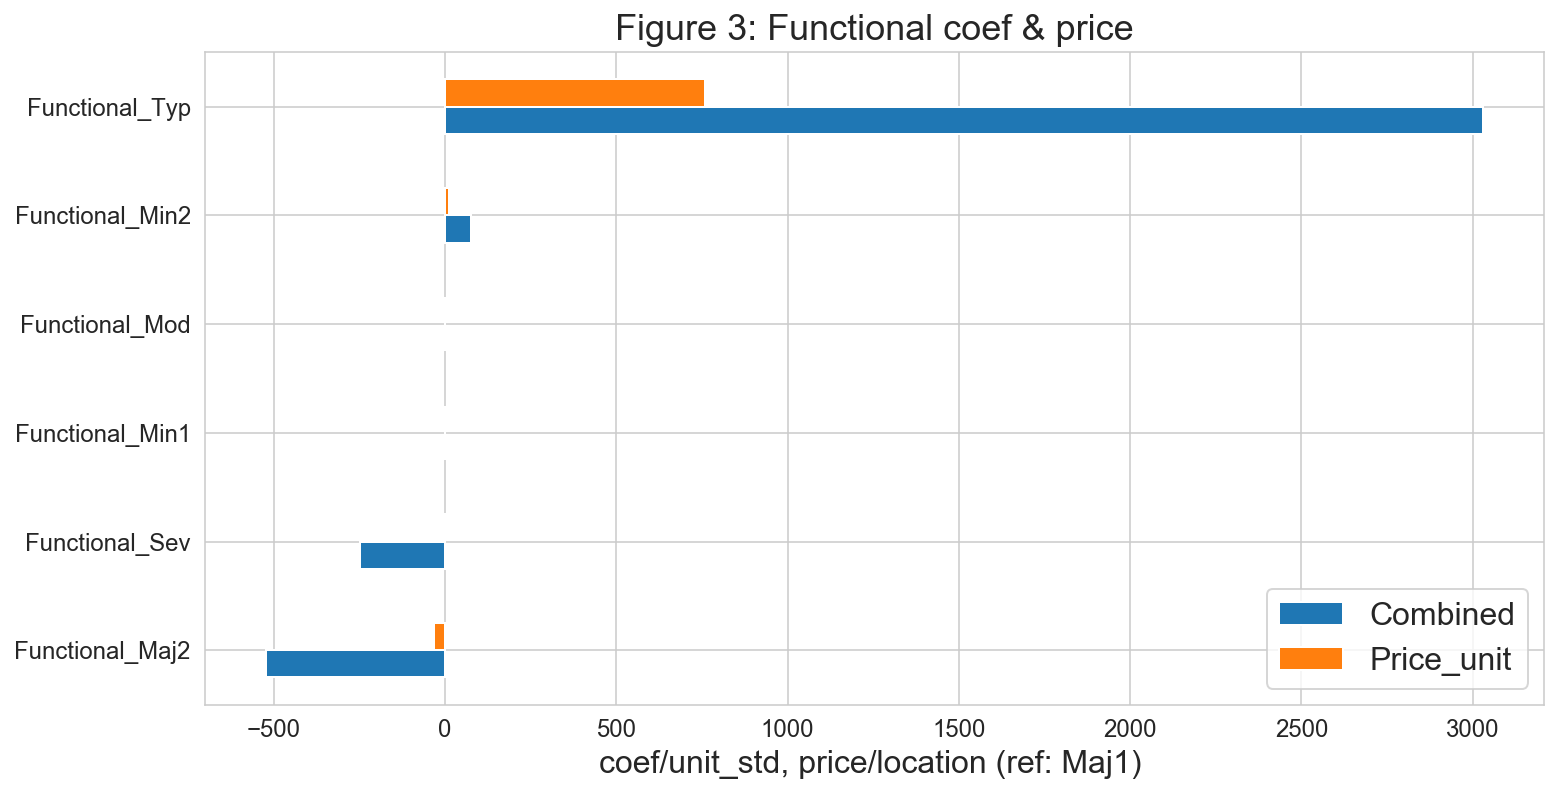

In [154]:
# Functional
neigh_col = [index for index in combined_model_coef_q2.index if 'Functional' in index ]
ax = combined_model_coef_q2.loc[neigh_col,:].sort_values(by='Combined').plot(kind='barh' )
plt.gcf().set_size_inches(12,6)
plt.title('Figure 3: Functional coef & price', fontsize=18)
ax.tick_params(labelsize=12)
plt.legend(prop={'size': 16})
ax.set_xlabel('coef/unit_std, price/location (ref: Maj1) ',size=16)

Text(0.5, 0, 'coef/unit_std, price/location (ref: OverallCond_1) ')

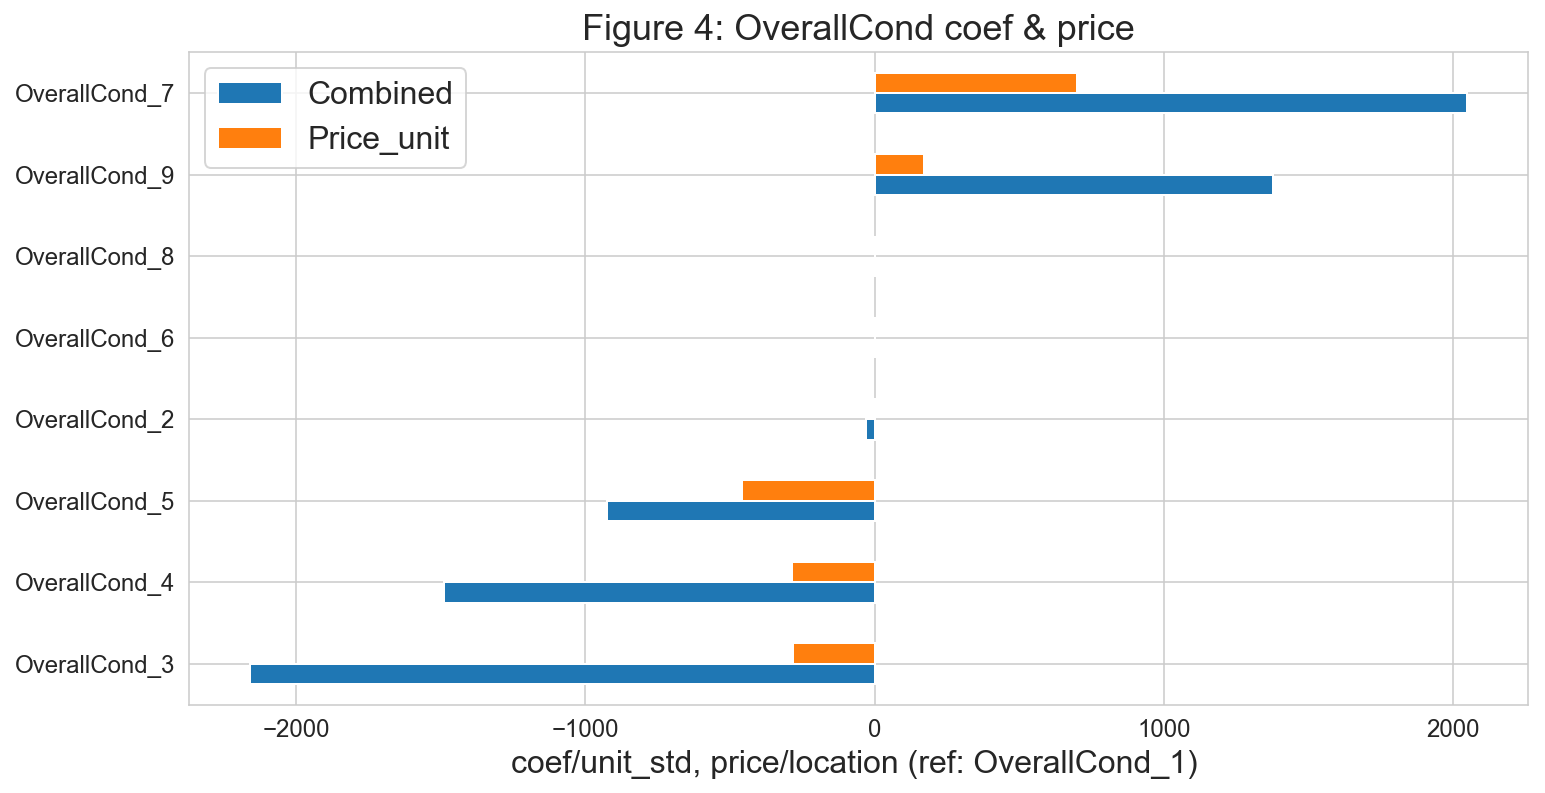

In [155]:
# OverallCond

neigh_col = [index for index in combined_model_coef_q2.index if 'OverallCond' in index ]
ax = combined_model_coef_q2.loc[neigh_col,:].sort_values(by='Combined').plot(kind='barh' )
plt.gcf().set_size_inches(12,6)
plt.title('Figure 4: OverallCond coef & price', fontsize=18)
ax.tick_params(labelsize=12)
plt.legend(prop={'size': 16})
ax.set_xlabel('coef/unit_std, price/location (ref: OverallCond_1) ',size=16)

## How to use the model to evaluate the house or fixed up
1. To identify whether the house is worth to buy or not: can put the fixed characters into model 1 and renovated character in model 2, the predictions sum shall show around the house value without consider the selling time and condition. Can determine whether it is worth to buy or not
2. To check renovation possiblity, in the second model shows the difference in value for each feature. Compare the unit value and the renovation cost, can determine whether the renovation worth the cost or not. For example, basement renovation can be useful, since pre sqft unfinished basement bring down 142 dollar, the cost of renovate basement maybe lower than 142 dollar. In the other hand, changing the whole exterior may not be cost-effective.


## The model reliability
1. The model 2 do bring down the mean absolute error in the prediction of price, but limited
2. Some of the features coef can be explained, some features in the same category may not be as effective as others. May caused by the inbalanced dataset
3. However, there is still high price varience in the model, the selling time and condition need to be take into consideration. As metioned in question 1 the selling month do give difference in the price.
4. recommend to get more balanced dataset, and consider the selling factor.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [156]:
# construct the predictor and target
q3_df = house_residential.copy()
q3_df.SaleCondition = (q3_df.SaleCondition== 'Abnorml').map({False : 0, True : 1})

In [157]:
q3_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'sold_built_age', 'YearRemodAdd', 'sold_Remod_age', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'have_garage', 'sold_Garage_age', 'GarageFinish

In [158]:
# drop redundant and not house related cols
q3_df.drop(columns=['Id', 'YearBuilt', 'YearRemodAdd','1stFlrSF', '2ndFlrSF', 'GarageYrBlt','GarageArea','WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch','MoSold', 'SaleType','SalePrice'], inplace=True)

In [159]:
q3_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'sold_built_age', 'sold_Remod_age',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'have_garage',
       'sold_Garage_age', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolArea', 'Po

In [160]:
# adding dummies
dummy_col = [col for col in q3_df if q3_df[col].dtype==object]
dummy_col.extend(['MSSubClass', 'OverallQual', 'OverallCond'])
auto_dummy_col = [col for col in dummy_col if col not in ['BsmtFinType1', 'BsmtFinType2']]
q3_df = pd.get_dummies(q3_df, columns=auto_dummy_col, drop_first=True)

# handle 'BsmtFinType1', 'BsmtFinType2' separately, to get type1 type2 size as value
q3_df = pd.get_dummies(q3_df, columns=['BsmtFinType1', 'BsmtFinType2'], drop_first=False)
q3_df.drop(columns=['BsmtFinType1_NA', 'BsmtFinType2_NA'], inplace=True)
BsmtFinType1_col = [col for col in q3_df.columns if 'BsmtFinType1' in col]
BsmtFinType2_col = [col for col in q3_df.columns if 'BsmtFinType2' in col]

q3_df.loc[:,BsmtFinType1_col]= q3_df.loc[:,BsmtFinType1_col].apply(lambda x: x*q3_df.BsmtFinSF1)
q3_df.loc[:,BsmtFinType2_col]= q3_df.loc[:,BsmtFinType2_col].apply(lambda x: x*q3_df.BsmtFinSF2)
q3_df.drop(columns=['BsmtFinSF1','BsmtFinSF2'], inplace=True)


In [161]:
# train test splite

q3_train = q3_df[q3_df.YrSold<2010]
q3_test = q3_df[q3_df.YrSold==2010]

In [162]:
# adding check training data positive, negtive data ratio, around 7 percent
q3_train.SaleCondition.value_counts()

0    1191
1      87
Name: SaleCondition, dtype: int64

In [163]:
# adding check testing data positive, negtive data ratio, arount 5 precent
q3_test.SaleCondition.value_counts()

0    163
1      9
Name: SaleCondition, dtype: int64

In [164]:
# Separate X y
X_train_q3 = q3_train.drop(columns=['YrSold', 'SaleCondition'])
y_train_q3 = q3_train.SaleCondition

In [165]:
# Separate X y
X_test_q3 = q3_test.drop(columns=['YrSold', 'SaleCondition'])
y_test_q3 = q3_test.SaleCondition

In [166]:
# standardarize
scaler3 = StandardScaler()
X_train_std_q3 = scaler3.fit_transform(X_train_q3)
X_test_std_q3 = scaler3.transform(X_test_q3)


C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [167]:
# baseline for training data will be all negative
y_train_baseline = [0 for i in range(len(y_train_q3))]
print(classification_report(y_train_q3, y_train_baseline))

fpr, tp4, _ = roc_curve(y_train_q3, y_train_baseline)
print(f"auc_train {auc(fpr, tp4)}")

pd.DataFrame(confusion_matrix(y_train_q3, y_train_baseline), columns=['Normal_predict','Abnormal_predict'], index = ['Normal_real','Abnormal_real'])


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1191
           1       0.00      0.00      0.00        87

   micro avg       0.93      0.93      0.93      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.87      0.93      0.90      1278

auc_train 0.5


C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Normal_predict,Abnormal_predict
Normal_real,1191,0
Abnormal_real,87,0


In [168]:
# baseline for test data will be all negative
y_test_baseline = [0 for i in range(len(y_test_q3))]

fpr, tp4, _ = roc_curve(y_test_q3, y_test_baseline)
print(f"auc_test {auc(fpr, tp4)}")

print(classification_report(y_test_q3, y_test_baseline))

pd.DataFrame(confusion_matrix(y_test_q3, y_test_baseline), columns=['Normal_predict','Abnormal_predict'], index = ['Normal_real','Abnormal_real'])


auc_test 0.5
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.95      0.95      0.95       172
   macro avg       0.47      0.50      0.49       172
weighted avg       0.90      0.95      0.92       172



C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Normal_predict,Abnormal_predict
Normal_real,163,0
Abnormal_real,9,0


## Model fitting, logistic regression and SVM

In [170]:
## Model 1: setting upsampled Logistic regression with different class weight and C
## Using SMOTE to upsample the minority data, and using the imbalance learn piplline that will not affect the testing result
## However, this model was not good

# smt = SMOTE(random_state=42,sampling_strategy='minority')
# logR = LogisticRegression(max_iter=1000)
# smt_logR_pipeline = imPipeline([('smt', smt), ('logR', logR)])
# print(smt_logR_pipeline.get_params().keys())
# smt_logR_parameter = {'smt__k_neighbors': [5],
#                      'logR__C': 10**np.linspace(-0.5, 2.5, 10),
#                      'logR__class_weight': [ {1:3, 0:1}],
#                      'logR__penalty':['l1']}
# smt_logR_Grid = GridSearchCV(smt_logR_pipeline, smt_logR_parameter, cv=3, scoring='f1_macro', n_jobs=7 )
# smt_logR_Grid.fit(X_train_std_q3, y_train_q3)

In [171]:
# the best estimator for smt_logR_Grid
smt_logR_Grid.best_estimator_

Pipeline(memory=None,
     steps=[('smt', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=42, ratio=None,
   sampling_strategy='minority', svm_estimator='deprecated')), ('logR', LogisticRegression(C=31.622776601683793, class_weight={1: 3, 0: 1},
          dual...1',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False))])

In [172]:
# Train set review
print(f"cv best scroe auc: {smt_logR_Grid.best_score_}")
y_predict = smt_logR_Grid.best_estimator_.predict(X_train_std_q3)
print(classification_report(y_train_q3, y_predict))
fpr, tp4, _ = roc_curve(y_train_q3, y_predict)
print(f"auc_train {auc(fpr, tp4)}")
pd.DataFrame(confusion_matrix(y_train_q3, y_predict), columns=['Normal_predict','Abnormal_predict'], index = ['Normal_real','Abnormal_real'])


cv best scroe f1_macro: 0.5178993289298954
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1191
           1       0.29      1.00      0.45        87

   micro avg       0.83      0.83      0.83      1278
   macro avg       0.64      0.91      0.67      1278
weighted avg       0.95      0.83      0.87      1278

auc_train 0.910159529806885


,Normal_predict,Abnormal_predict
Normal_real,977,214
Abnormal_real,0,87


In [173]:
# Test data review
y_test_predict = smt_logR_Grid.best_estimator_.predict(X_test_std_q3)
print(classification_report(y_test_q3, y_test_predict))
fpr, tp4, _ = roc_curve(y_test_q3, y_test_predict)
print(f"auc_test {auc(fpr, tp4)}")
pd.DataFrame(confusion_matrix(y_test_q3, y_test_predict), columns=['Normal_predict','Abnormal_predict'], index = ['Normal_real','Abnormal_real'])


              precision    recall  f1-score   support

           0       0.94      0.69      0.80       163
           1       0.04      0.22      0.07         9

   micro avg       0.67      0.67      0.67       172
   macro avg       0.49      0.46      0.43       172
weighted avg       0.89      0.67      0.76       172

auc_test 0.45773687798227675


,Normal_predict,Abnormal_predict
Normal_real,113,50
Abnormal_real,7,2


In [ ]:
# pickle.dump( [ smt_logR_Grid], open( "save_result_q3_t4.p", "wb" ) )

In [ ]:
## Model 2: setting upsampled SVM with different class weight gamma and C
## Using SMOTE to upsample the minority data, and using the imbalance learn piplline that will not affect the testing result
## However, this model was not good 

smt = SVMSMOTE(random_state=42, sampling_strategy='minority')
svc = SVC(kernel='linear')
smt_svc_pipeline = imPipeline([('smt', smt), ('svc', svc)])

svc_parameter = {'svc__gamma': np.linspace(0.0001, 5, 15),
                 'svc__C':10**np.linspace(-5, 3, 15),
                'svc__class_weight': [{1:1, 0:1}, {1:2, 0:1} ]}


print(smt_svc_pipeline.get_params().keys())


smt_svc_Grid = GridSearchCV(smt_svc_pipeline, svc_parameter, cv=5, scoring='roc_auc', n_jobs=7, verbose=1 )
smt_svc_Grid.fit(X_train_std_q3, y_train_q3)

dict_keys(['memory', 'steps', 'smt', 'svc', 'smt__k_neighbors', 'smt__m_neighbors', 'smt__n_jobs', 'smt__out_step', 'smt__random_state', 'smt__sampling_strategy', 'smt__svm_estimator', 'svc__C', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   22.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  4.1min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  6.3min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  8.2min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 16.7min


In [250]:
smt_svc_Grid.best_estimator_

Pipeline(memory=None,
     steps=[('smt', SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
     random_state=42, sampling_strategy='minority', svm_estimator=None)), ('svc', SVC(C=0.01, cache_size=200, class_weight={1: 14, 0: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [251]:
# Train set review
print(f"cv best scroe f1_macro: {smt_svc_Grid.best_score_}")
y_predict = smt_svc_Grid.best_estimator_.predict(X_train_std_q3)
print(classification_report(y_train_q3, y_predict))
fpr, tp4, _ = roc_curve(y_train_q3, y_predict)
print(f"auc_train {auc(fpr, tp4)}")
pd.DataFrame(confusion_matrix(y_train_q3, y_predict), columns=['Normal_predict','Abnormal_predict'], index = ['Normal_real','Abnormal_real'])


cv best scroe f1_macro: 0.4750289788713435
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      1191
           1       0.21      1.00      0.35        87

   micro avg       0.75      0.75      0.75      1278
   macro avg       0.61      0.87      0.60      1278
weighted avg       0.95      0.75      0.81      1278

auc_train 0.86607892527288


,Normal_predict,Abnormal_predict
Normal_real,872,319
Abnormal_real,0,87


In [252]:
# Test data review
y_test_predict = smt_svc_Grid.best_estimator_.predict(X_test_std_q3)
print(classification_report(y_test_q3, y_test_predict))
fpr, tp4, _ = roc_curve(y_test_q3, y_test_predict)
print(f"auc_test {auc(fpr, tp4)}")
pd.DataFrame(confusion_matrix(y_test_q3, y_test_predict), columns=['Normal_predict','Abnormal_predict'], index = ['Normal_real','Abnormal_real'])


              precision    recall  f1-score   support

           0       0.93      0.58      0.71       163
           1       0.03      0.22      0.05         9

   micro avg       0.56      0.56      0.56       172
   macro avg       0.48      0.40      0.38       172
weighted avg       0.88      0.56      0.68       172

auc_test 0.3994546693933197


,Normal_predict,Abnormal_predict
Normal_real,94,69
Abnormal_real,7,2


In [169]:
svc = SVC(kernel='linear',class_weight='balanced' )
svc_parameter2 = {'gamma': np.linspace(0.0001, 10, 20),
                 'C':10**np.linspace(-5, 5, 20)}
svc_Grid = GridSearchCV(svc, svc_parameter2, cv=5, scoring='f1_macro', n_jobs=7, verbose=1 )
svc_Grid.fit(X_train_std_q3, y_train_q3)


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   16.3s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  3.9min


KeyboardInterrupt: 

In [254]:
# Train set review
print(f"cv best scroe f1_macro: {svc_Grid.best_score_}")
y_predict = svc_Grid.best_estimator_.predict(X_train_std_q3)
print(classification_report(y_train_q3, y_predict))
fpr, tp4, _ = roc_curve(y_train_q3, y_predict)
print(f"auc_train {auc(fpr, tp4)}")
pd.DataFrame(confusion_matrix(y_train_q3, y_predict), columns=['Normal_predict','Abnormal_predict'], index = ['Normal_real','Abnormal_real'])


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'